In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from functools import partial
from itertools import combinations

import numpy as np
import jax
from jax import random
from jax import numpy as jnp
from flax.training.checkpoints import save_checkpoint, restore_checkpoint
import distrax
import wandb
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import src.models as models
from src.models import make_PoG_Ens_loss, make_Reg_Ens_loss, make_PoN_Ens_loss
from src.models import make_PoG_Ens_plots, make_Reg_Ens_plots, make_PoN_Ens_plots
import src.data
from src.data import NumpyLoader
from src.utils.training import setup_training, train_loop
from experiments.configs.comparison_figures_pog import get_config as get_pog_config
from experiments.configs.comparison_figures_reg_ens import get_config as get_reg_ens_config
from experiments.configs.comparison_figures_pon import get_config as get_pon_config
from src.models.pog import calculate_pog_loc_scale
from src.models.reg_ens import calculate_ens_loc_scale
from src.models.pon import normal_prod

2022-12-13 17:05:42.789626: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-13 17:05:43.382828: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-13 17:05:43.382930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-13 17:05:43.382939: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [12]:
ENS_RETRAIN = True
POG_RETRAIN = False
PON_RETRAIN = True

In [4]:
os.environ['XLA_FLAGS'] = "--xla_gpu_force_compilation_parallelism=1"

In [5]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'reg_comparison_figures.ipynb'
# ^ W&B doesn't know how to handle VS Code notebooks.

wandb.login()

wandb: Currently logged in as: metodj. Use `wandb login --relogin` to force relogin


True

## PoG Training

In [6]:
config = get_pog_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_x = train_dataset[0][0]
init_y = train_dataset[0][1]


best_pog_states = []
for i in range(1):
    rng = random.PRNGKey(i)

    setup_rng, rng = random.split(rng)

    pog_model, state = setup_training(config, setup_rng, init_x, init_y)

    if POG_RETRAIN:  # RETRAIN
        state, best_state = train_loop(
            pog_model, state, config, rng, partial(make_PoG_Ens_loss, per_member_loss=True), partial(make_PoG_Ens_loss, per_member_loss=True), train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'offline',
                # 'notes': '',
            },
            plot_fn=make_PoG_Ens_plots,
        )

        best_pog_states.append(best_state)

        save_checkpoint(f'dynNN_results/pog_model_{i}_presentation', best_state, 1, overwrite=True)

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

In [7]:
# if POG_RETRAIN:  # RETRAIN
#     save_checkpoint('dynNN_results/pog_models', best_pog_states, 1)

## Reg Ens training

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

2022-12-13 17:08:02.666065: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-13 17:08:03.223564: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-13 17:08:03.223648: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-13 17:08:03.223656: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


  0%|          | 0/201 [00:00<?, ?it/s]

epoch:   1 - train loss: 9.37605, val loss: 8.40488, train err: 0.6576, val err: 1.1158, lr: 0.00010
Best val_err
epoch:   2 - train loss: 9.07562, val loss: 8.41479, train err: 0.5667, val err: 1.1073, lr: 0.00010
Best val_err
epoch:   3 - train loss: 8.79693, val loss: 8.40273, train err: 0.5247, val err: 1.0937, lr: 0.00010
Best val_err
epoch:   4 - train loss: 8.54458, val loss: 8.37113, train err: 0.4857, val err: 1.0759, lr: 0.00010
Best val_err
epoch:   5 - train loss: 8.26922, val loss: 8.32121, train err: 0.4435, val err: 1.0540, lr: 0.00010
Best val_err
epoch:   6 - train loss: 7.97910, val loss: 8.25471, train err: 0.3998, val err: 1.0282, lr: 0.00010
Best val_err
epoch:   7 - train loss: 7.68483, val loss: 8.16839, train err: 0.3542, val err: 0.9982, lr: 0.00010
Best val_err
epoch:   8 - train loss: 7.41239, val loss: 8.07019, train err: 0.3115, val err: 0.9652, lr: 0.00010
Best val_err
epoch:   9 - train loss: 7.16119, val loss: 7.96300, train err: 0.2731, val err: 0.9302,

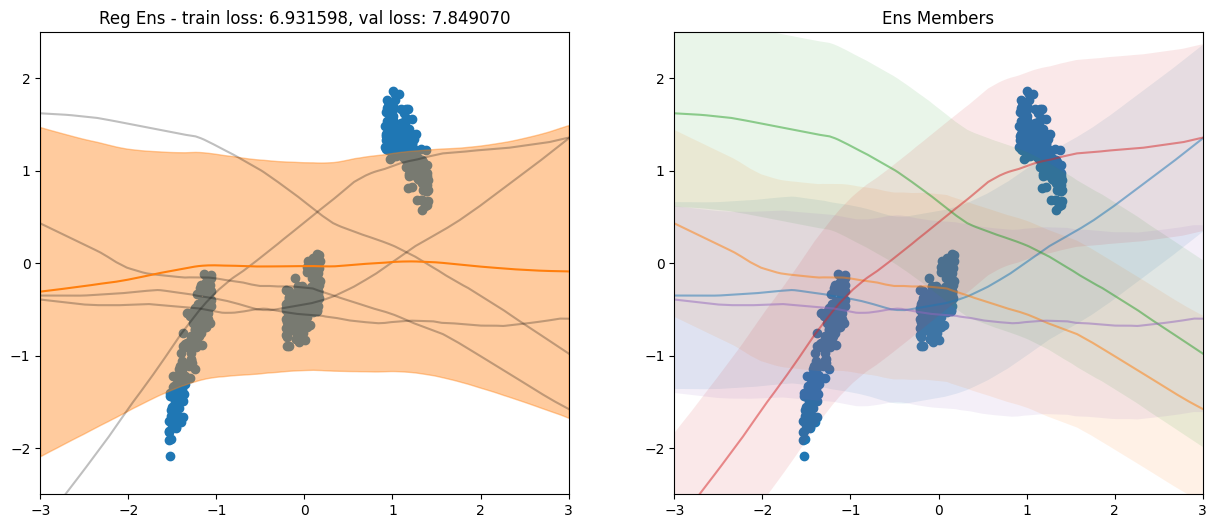

Best val_err
epoch:  11 - train loss: 6.72822, val loss: 7.73086, train err: 0.2075, val err: 0.8560, lr: 0.00010
Best val_err
epoch:  12 - train loss: 6.55196, val loss: 7.61018, train err: 0.1815, val err: 0.8178, lr: 0.00010
Best val_err
epoch:  13 - train loss: 6.39606, val loss: 7.48863, train err: 0.1583, val err: 0.7793, lr: 0.00010
Best val_err
epoch:  14 - train loss: 6.26974, val loss: 7.36732, train err: 0.1443, val err: 0.7406, lr: 0.00010
Best val_err
epoch:  15 - train loss: 6.15757, val loss: 7.24767, train err: 0.1288, val err: 0.7027, lr: 0.00010
Best val_err
epoch:  16 - train loss: 6.06181, val loss: 7.13082, train err: 0.1163, val err: 0.6658, lr: 0.00010
Best val_err
epoch:  17 - train loss: 5.98139, val loss: 7.01740, train err: 0.1070, val err: 0.6301, lr: 0.00010
Best val_err
epoch:  18 - train loss: 5.91290, val loss: 6.90829, train err: 0.0997, val err: 0.5960, lr: 0.00010
Best val_err
epoch:  19 - train loss: 5.85422, val loss: 6.80351, train err: 0.0942, val

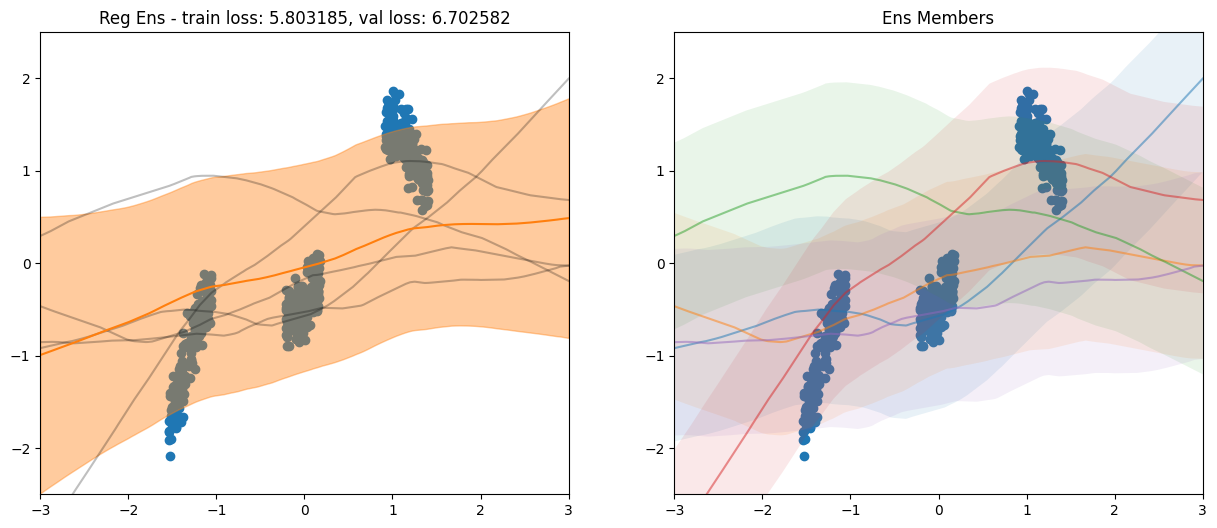

Best val_err
epoch:  21 - train loss: 5.75738, val loss: 6.60674, train err: 0.0868, val err: 0.5022, lr: 0.00010
Best val_err
epoch:  22 - train loss: 5.71530, val loss: 6.51677, train err: 0.0844, val err: 0.4747, lr: 0.00010
Best val_err
epoch:  23 - train loss: 5.67594, val loss: 6.43222, train err: 0.0822, val err: 0.4492, lr: 0.00010
Best val_err
epoch:  24 - train loss: 5.63864, val loss: 6.35240, train err: 0.0804, val err: 0.4253, lr: 0.00010
Best val_err
epoch:  25 - train loss: 5.60188, val loss: 6.27703, train err: 0.0789, val err: 0.4032, lr: 0.00010
Best val_err
epoch:  26 - train loss: 5.56558, val loss: 6.20527, train err: 0.0775, val err: 0.3824, lr: 0.00010
Best val_err
epoch:  27 - train loss: 5.52918, val loss: 6.13709, train err: 0.0762, val err: 0.3631, lr: 0.00010
Best val_err
epoch:  28 - train loss: 5.49201, val loss: 6.07258, train err: 0.0748, val err: 0.3453, lr: 0.00010
Best val_err
epoch:  29 - train loss: 5.45427, val loss: 6.01137, train err: 0.0734, val

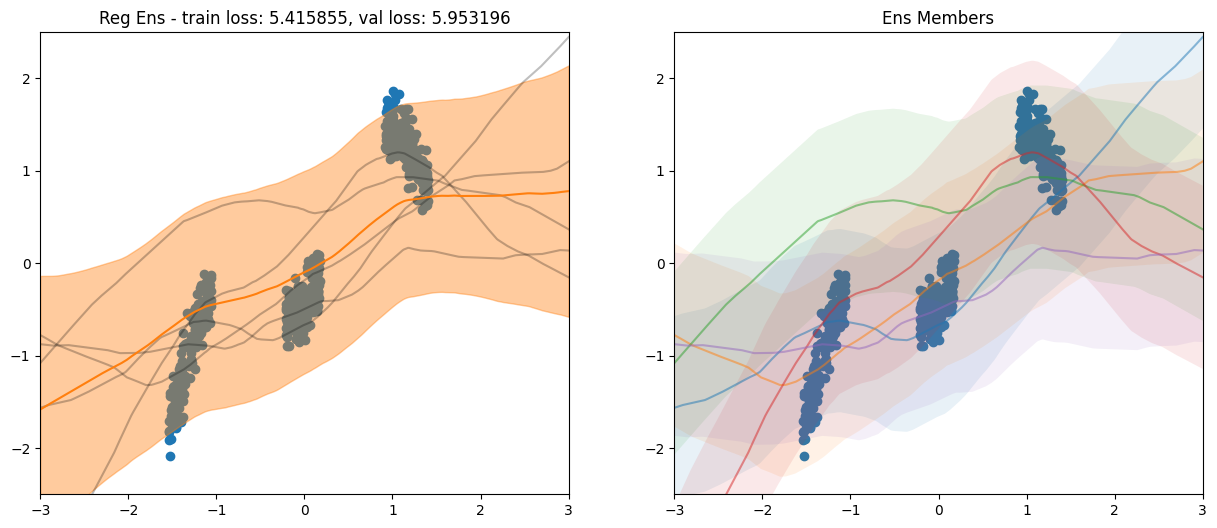

Best val_err
epoch:  31 - train loss: 5.37659, val loss: 5.89829, train err: 0.0703, val err: 0.2998, lr: 0.00010
Best val_err
epoch:  32 - train loss: 5.33720, val loss: 5.84588, train err: 0.0686, val err: 0.2871, lr: 0.00010
Best val_err
epoch:  33 - train loss: 5.29763, val loss: 5.79600, train err: 0.0670, val err: 0.2755, lr: 0.00010
Best val_err
epoch:  34 - train loss: 5.25795, val loss: 5.74831, train err: 0.0654, val err: 0.2647, lr: 0.00010
Best val_err
epoch:  35 - train loss: 5.21831, val loss: 5.70236, train err: 0.0639, val err: 0.2545, lr: 0.00010
Best val_err
epoch:  36 - train loss: 5.17879, val loss: 5.65837, train err: 0.0624, val err: 0.2453, lr: 0.00010
Best val_err
epoch:  37 - train loss: 5.13937, val loss: 5.61614, train err: 0.0609, val err: 0.2368, lr: 0.00010
Best val_err
epoch:  38 - train loss: 5.10019, val loss: 5.57464, train err: 0.0595, val err: 0.2287, lr: 0.00010
Best val_err
epoch:  39 - train loss: 5.06139, val loss: 5.53346, train err: 0.0581, val

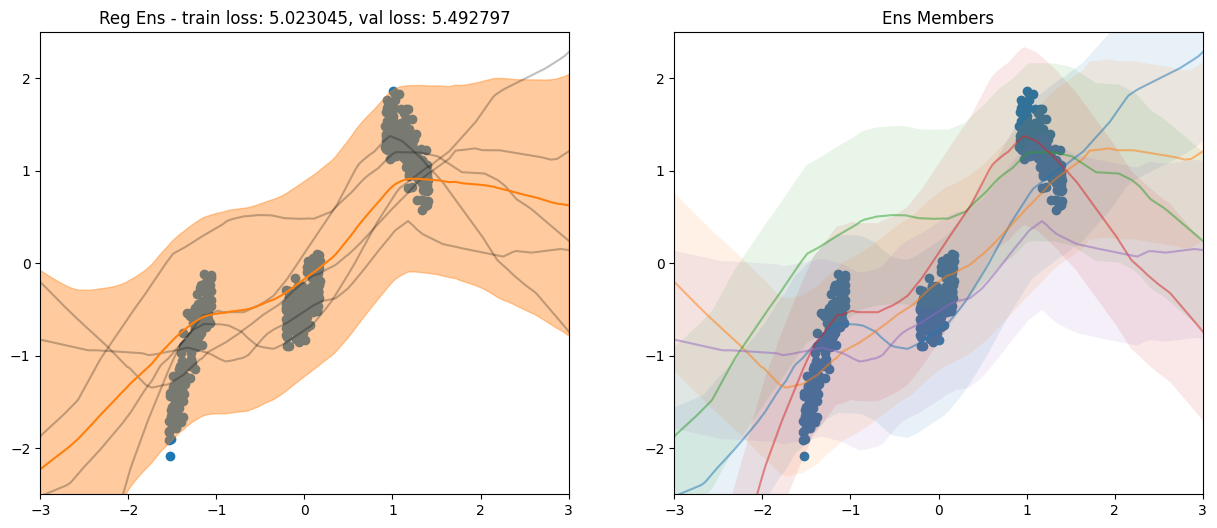

Best val_err
epoch:  41 - train loss: 4.98515, val loss: 5.45320, train err: 0.0556, val err: 0.2058, lr: 0.00010
Best val_err
epoch:  42 - train loss: 4.94795, val loss: 5.41384, train err: 0.0545, val err: 0.1986, lr: 0.00010
Best val_err
epoch:  43 - train loss: 4.91160, val loss: 5.37442, train err: 0.0534, val err: 0.1915, lr: 0.00010
Best val_err
epoch:  44 - train loss: 4.87616, val loss: 5.33482, train err: 0.0525, val err: 0.1844, lr: 0.00010
Best val_err
epoch:  45 - train loss: 4.84141, val loss: 5.29473, train err: 0.0516, val err: 0.1773, lr: 0.00010
Best val_err
epoch:  46 - train loss: 4.80733, val loss: 5.25471, train err: 0.0507, val err: 0.1704, lr: 0.00010
Best val_err
epoch:  47 - train loss: 4.77381, val loss: 5.21453, train err: 0.0500, val err: 0.1636, lr: 0.00010
Best val_err
epoch:  48 - train loss: 4.74074, val loss: 5.17313, train err: 0.0492, val err: 0.1566, lr: 0.00010
Best val_err
epoch:  49 - train loss: 4.70819, val loss: 5.13102, train err: 0.0485, val

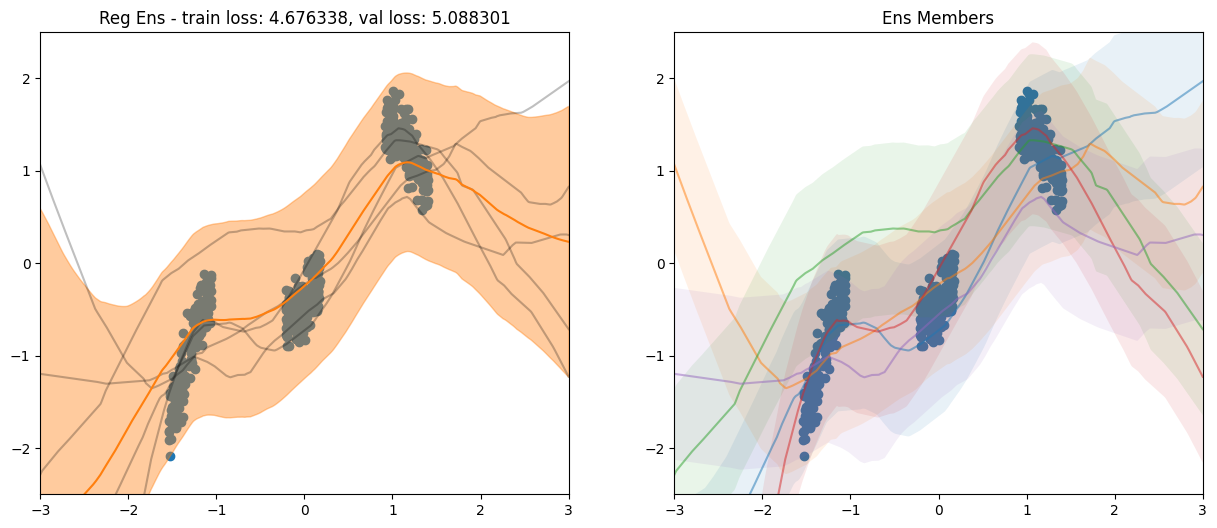

Best val_err
epoch:  51 - train loss: 4.64515, val loss: 5.04574, train err: 0.0473, val err: 0.1367, lr: 0.00010
Best val_err
epoch:  52 - train loss: 4.61440, val loss: 5.00380, train err: 0.0468, val err: 0.1309, lr: 0.00010
Best val_err
epoch:  53 - train loss: 4.58407, val loss: 4.96241, train err: 0.0463, val err: 0.1256, lr: 0.00010
Best val_err
epoch:  54 - train loss: 4.55397, val loss: 4.92160, train err: 0.0459, val err: 0.1206, lr: 0.00010
Best val_err
epoch:  55 - train loss: 4.52408, val loss: 4.88144, train err: 0.0454, val err: 0.1160, lr: 0.00010
Best val_err
epoch:  56 - train loss: 4.49448, val loss: 4.84174, train err: 0.0450, val err: 0.1118, lr: 0.00010
Best val_err
epoch:  57 - train loss: 4.46512, val loss: 4.80225, train err: 0.0446, val err: 0.1079, lr: 0.00010
Best val_err
epoch:  58 - train loss: 4.43599, val loss: 4.76282, train err: 0.0442, val err: 0.1042, lr: 0.00010
Best val_err
epoch:  59 - train loss: 4.40708, val loss: 4.72347, train err: 0.0438, val

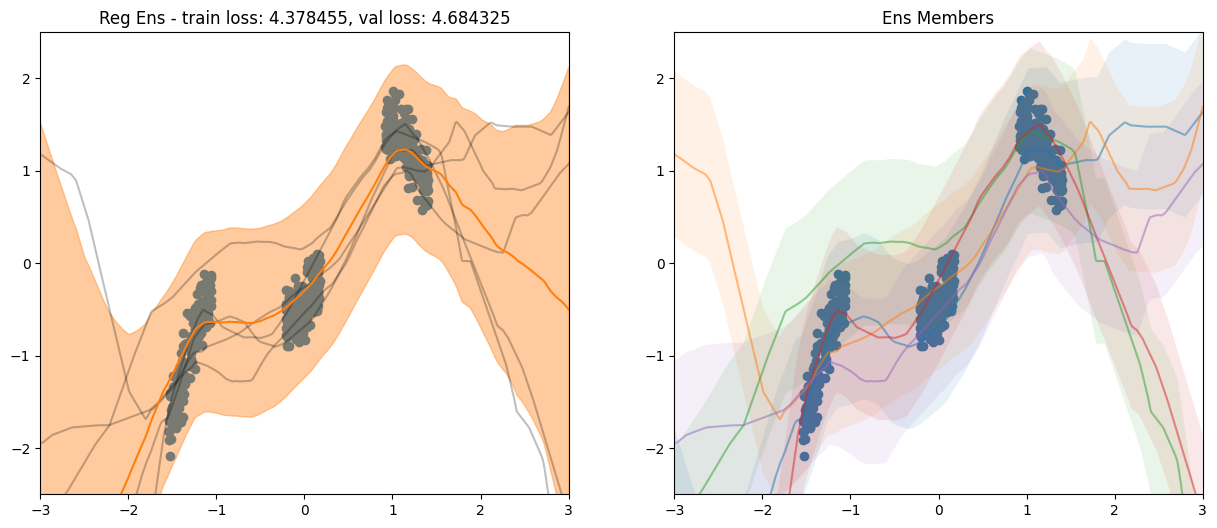

Best val_err
epoch:  61 - train loss: 4.35006, val loss: 4.64538, train err: 0.0431, val err: 0.0942, lr: 0.00010
Best val_err
epoch:  62 - train loss: 4.32186, val loss: 4.60680, train err: 0.0428, val err: 0.0913, lr: 0.00010
Best val_err
epoch:  63 - train loss: 4.29388, val loss: 4.56853, train err: 0.0425, val err: 0.0885, lr: 0.00010
Best val_err
epoch:  64 - train loss: 4.26611, val loss: 4.53070, train err: 0.0421, val err: 0.0860, lr: 0.00010
Best val_err
epoch:  65 - train loss: 4.23856, val loss: 4.49316, train err: 0.0418, val err: 0.0837, lr: 0.00010
Best val_err
epoch:  66 - train loss: 4.21119, val loss: 4.45597, train err: 0.0415, val err: 0.0815, lr: 0.00010
Best val_err
epoch:  67 - train loss: 4.18404, val loss: 4.41879, train err: 0.0412, val err: 0.0794, lr: 0.00010
Best val_err
epoch:  68 - train loss: 4.15709, val loss: 4.38156, train err: 0.0410, val err: 0.0774, lr: 0.00010
Best val_err
epoch:  69 - train loss: 4.13030, val loss: 4.34483, train err: 0.0407, val

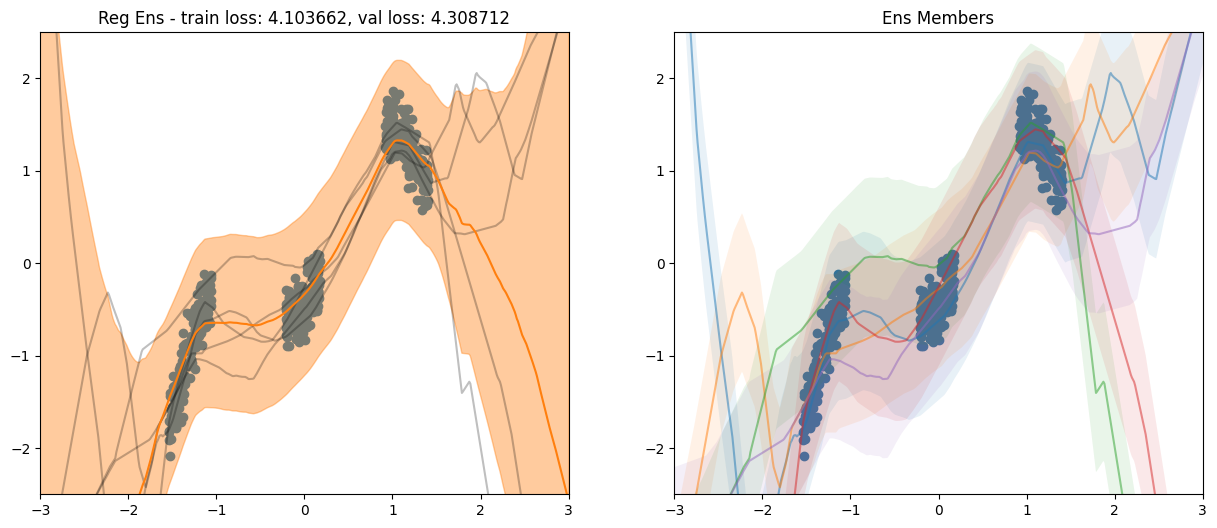

Best val_err
epoch:  71 - train loss: 4.07714, val loss: 4.27325, train err: 0.0402, val err: 0.0726, lr: 0.00010
Best val_err
epoch:  72 - train loss: 4.05076, val loss: 4.23800, train err: 0.0399, val err: 0.0712, lr: 0.00010
Best val_err
epoch:  73 - train loss: 4.02452, val loss: 4.20298, train err: 0.0397, val err: 0.0699, lr: 0.00010
Best val_err
epoch:  74 - train loss: 3.99850, val loss: 4.16766, train err: 0.0395, val err: 0.0686, lr: 0.00010
Best val_err
epoch:  75 - train loss: 3.97261, val loss: 4.13260, train err: 0.0392, val err: 0.0672, lr: 0.00010
Best val_err
epoch:  76 - train loss: 3.94684, val loss: 4.09745, train err: 0.0390, val err: 0.0658, lr: 0.00010
Best val_err
epoch:  77 - train loss: 3.92120, val loss: 4.06238, train err: 0.0388, val err: 0.0644, lr: 0.00010
Best val_err
epoch:  78 - train loss: 3.89565, val loss: 4.02797, train err: 0.0386, val err: 0.0631, lr: 0.00010
Best val_err
epoch:  79 - train loss: 3.87021, val loss: 3.99430, train err: 0.0384, val

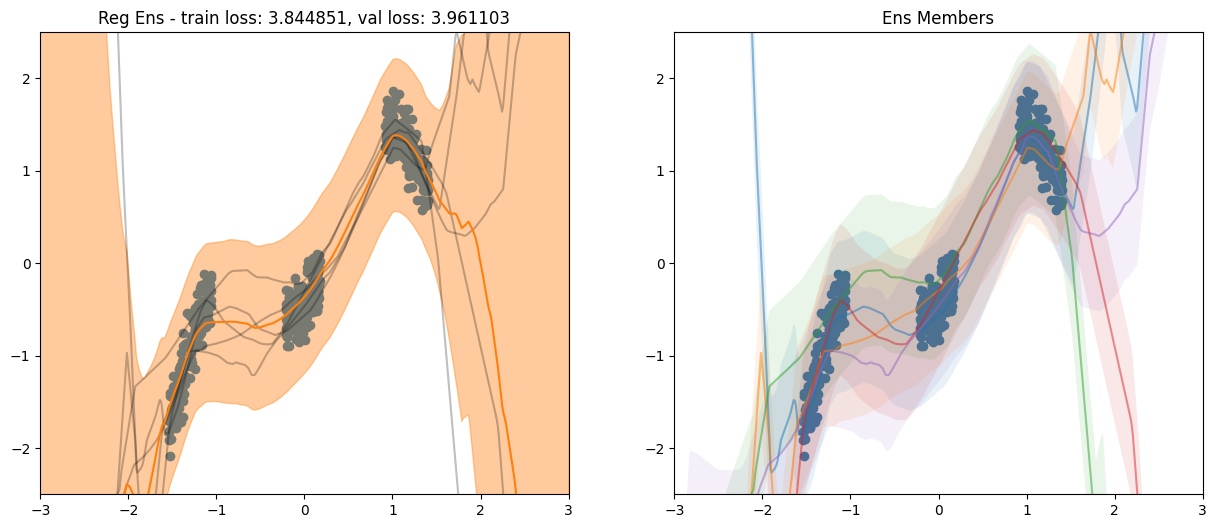

Best val_err
epoch:  81 - train loss: 3.81957, val loss: 3.92866, train err: 0.0380, val err: 0.0597, lr: 0.00010
Best val_err
epoch:  82 - train loss: 3.79434, val loss: 3.89703, train err: 0.0378, val err: 0.0587, lr: 0.00010
Best val_err
epoch:  83 - train loss: 3.76916, val loss: 3.86619, train err: 0.0376, val err: 0.0578, lr: 0.00010
Best val_err
epoch:  84 - train loss: 3.74407, val loss: 3.83623, train err: 0.0374, val err: 0.0569, lr: 0.00010
Best val_err
epoch:  85 - train loss: 3.71898, val loss: 3.80710, train err: 0.0372, val err: 0.0560, lr: 0.00010
Best val_err
epoch:  86 - train loss: 3.69384, val loss: 3.77875, train err: 0.0370, val err: 0.0552, lr: 0.00010
Best val_err
epoch:  87 - train loss: 3.66862, val loss: 3.75105, train err: 0.0367, val err: 0.0544, lr: 0.00010
Best val_err
epoch:  88 - train loss: 3.64336, val loss: 3.72400, train err: 0.0365, val err: 0.0537, lr: 0.00010
Best val_err
epoch:  89 - train loss: 3.61798, val loss: 3.69761, train err: 0.0362, val

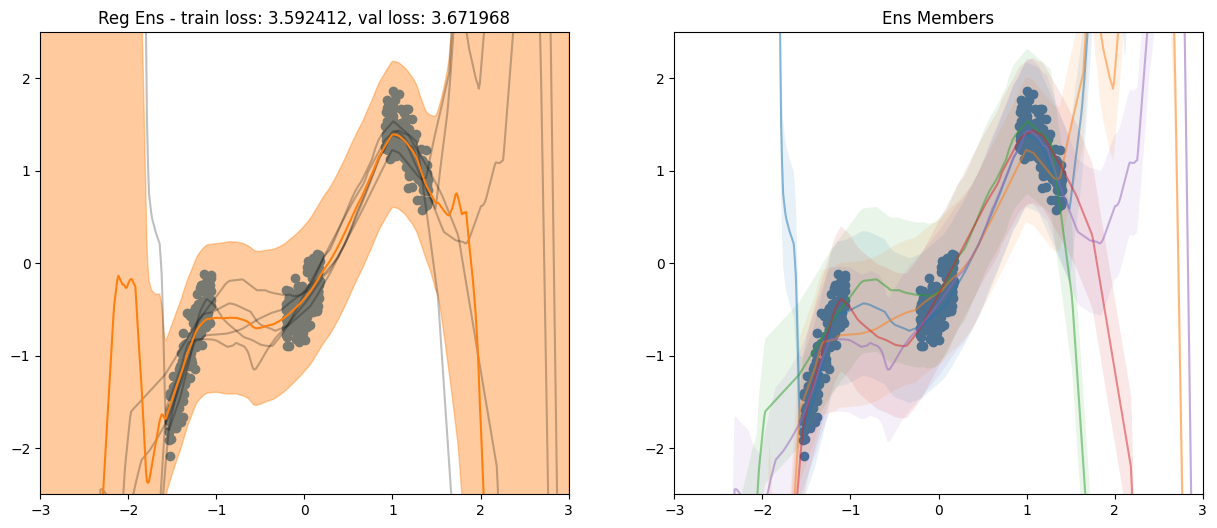

Best val_err
epoch:  91 - train loss: 3.56668, val loss: 3.64705, train err: 0.0357, val err: 0.0521, lr: 0.00010
Best val_err
epoch:  92 - train loss: 3.54101, val loss: 3.62284, train err: 0.0354, val err: 0.0517, lr: 0.00010
Best val_err
epoch:  93 - train loss: 3.51604, val loss: 3.59898, train err: 0.0351, val err: 0.0513, lr: 0.00010
Best val_err
epoch:  94 - train loss: 3.49283, val loss: 3.57490, train err: 0.0349, val err: 0.0510, lr: 0.00010
Best val_err
epoch:  95 - train loss: 3.47076, val loss: 3.54998, train err: 0.0348, val err: 0.0506, lr: 0.00010
Best val_err
epoch:  96 - train loss: 3.44785, val loss: 3.52396, train err: 0.0347, val err: 0.0501, lr: 0.00010
Best val_err
epoch:  97 - train loss: 3.42313, val loss: 3.49759, train err: 0.0345, val err: 0.0495, lr: 0.00010
Best val_err
epoch:  98 - train loss: 3.39765, val loss: 3.47144, train err: 0.0343, val err: 0.0490, lr: 0.00010
Best val_err
epoch:  99 - train loss: 3.37306, val loss: 3.44600, train err: 0.0342, val

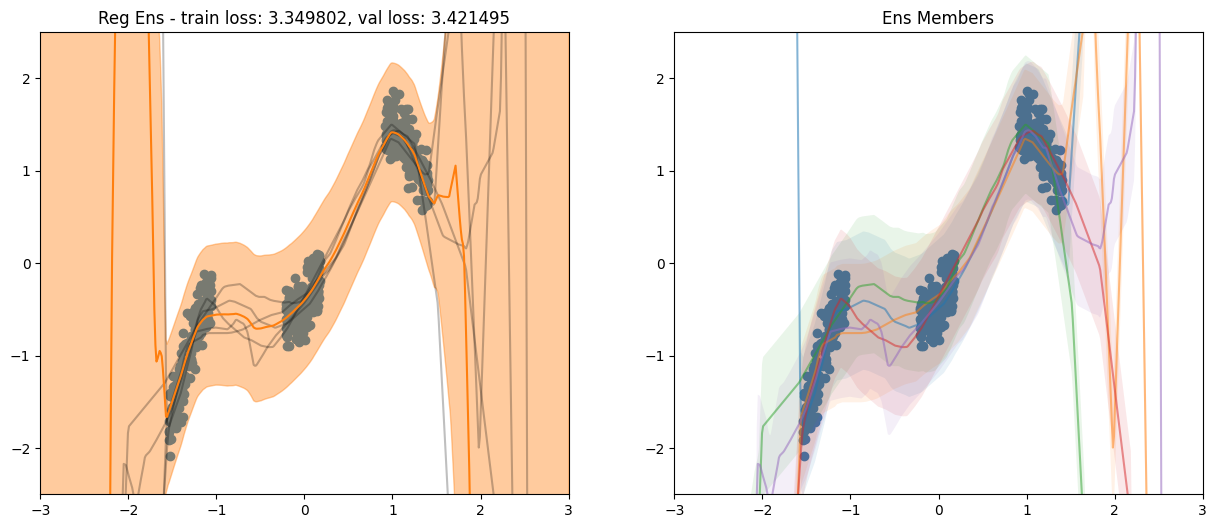

Best val_err
epoch: 101 - train loss: 3.32722, val loss: 3.39771, train err: 0.0341, val err: 0.0476, lr: 0.00010
Best val_err
epoch: 102 - train loss: 3.30459, val loss: 3.37424, train err: 0.0340, val err: 0.0473, lr: 0.00010
Best val_err
epoch: 103 - train loss: 3.28152, val loss: 3.35088, train err: 0.0339, val err: 0.0471, lr: 0.00010
Best val_err
epoch: 104 - train loss: 3.25786, val loss: 3.32760, train err: 0.0337, val err: 0.0468, lr: 0.00010
Best val_err
epoch: 105 - train loss: 3.23384, val loss: 3.30440, train err: 0.0335, val err: 0.0466, lr: 0.00010
Best val_err
epoch: 106 - train loss: 3.21007, val loss: 3.28138, train err: 0.0333, val err: 0.0464, lr: 0.00010
Best val_err
epoch: 107 - train loss: 3.18719, val loss: 3.25844, train err: 0.0332, val err: 0.0462, lr: 0.00010
Best val_err
epoch: 108 - train loss: 3.16494, val loss: 3.23538, train err: 0.0332, val err: 0.0459, lr: 0.00010
Best val_err
epoch: 109 - train loss: 3.14245, val loss: 3.21233, train err: 0.0331, val

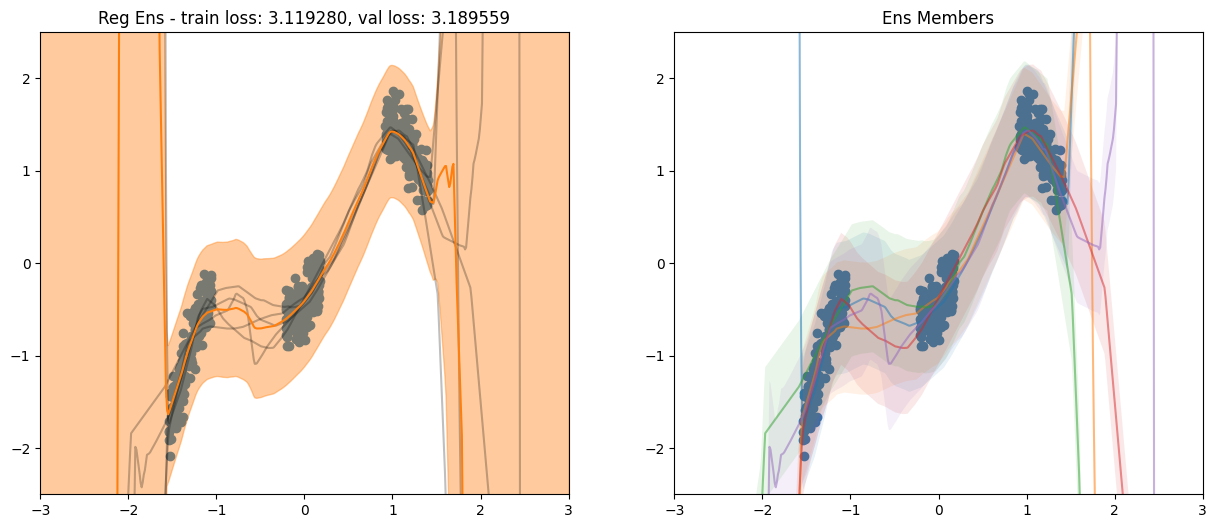

Best val_err
epoch: 111 - train loss: 3.09584, val loss: 3.16704, train err: 0.0329, val err: 0.0451, lr: 0.00010
Best val_err
epoch: 112 - train loss: 3.07280, val loss: 3.14471, train err: 0.0327, val err: 0.0448, lr: 0.00010
Best val_err
epoch: 113 - train loss: 3.05035, val loss: 3.12229, train err: 0.0326, val err: 0.0445, lr: 0.00010
Best val_err
epoch: 114 - train loss: 3.02805, val loss: 3.09953, train err: 0.0326, val err: 0.0442, lr: 0.00010
Best val_err
epoch: 115 - train loss: 3.00545, val loss: 3.07662, train err: 0.0325, val err: 0.0440, lr: 0.00010
Best val_err
epoch: 116 - train loss: 2.98252, val loss: 3.05361, train err: 0.0324, val err: 0.0438, lr: 0.00010
Best val_err
epoch: 117 - train loss: 2.95965, val loss: 3.03077, train err: 0.0323, val err: 0.0436, lr: 0.00010
Best val_err
epoch: 118 - train loss: 2.93717, val loss: 3.00825, train err: 0.0322, val err: 0.0434, lr: 0.00010
Best val_err
epoch: 119 - train loss: 2.91499, val loss: 2.98568, train err: 0.0321, val

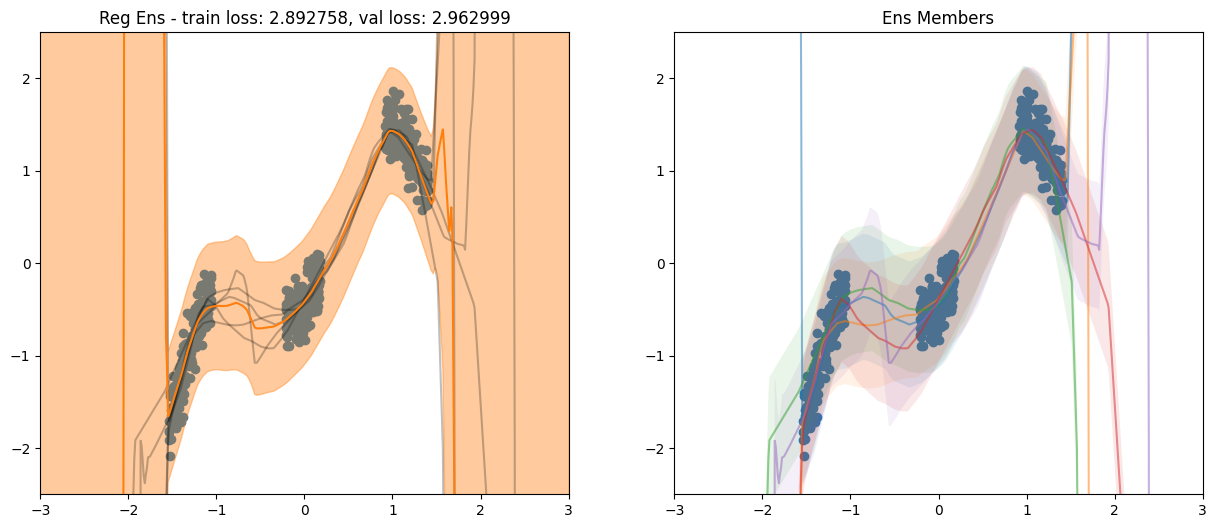

Best val_err
epoch: 121 - train loss: 2.87032, val loss: 2.94030, train err: 0.0320, val err: 0.0427, lr: 0.00010
Best val_err
epoch: 122 - train loss: 2.84785, val loss: 2.91774, train err: 0.0319, val err: 0.0424, lr: 0.00010
Best val_err
epoch: 123 - train loss: 2.82560, val loss: 2.89540, train err: 0.0319, val err: 0.0422, lr: 0.00010
Best val_err
epoch: 124 - train loss: 2.80358, val loss: 2.87293, train err: 0.0318, val err: 0.0421, lr: 0.00010
Best val_err
epoch: 125 - train loss: 2.78159, val loss: 2.85004, train err: 0.0318, val err: 0.0420, lr: 0.00010
Best val_err
epoch: 126 - train loss: 2.75952, val loss: 2.82655, train err: 0.0317, val err: 0.0419, lr: 0.00010
Best val_err
epoch: 127 - train loss: 2.73742, val loss: 2.80284, train err: 0.0317, val err: 0.0418, lr: 0.00010
Best val_err
epoch: 128 - train loss: 2.71547, val loss: 2.77914, train err: 0.0317, val err: 0.0417, lr: 0.00010
Best val_err
epoch: 129 - train loss: 2.69373, val loss: 2.75556, train err: 0.0317, val

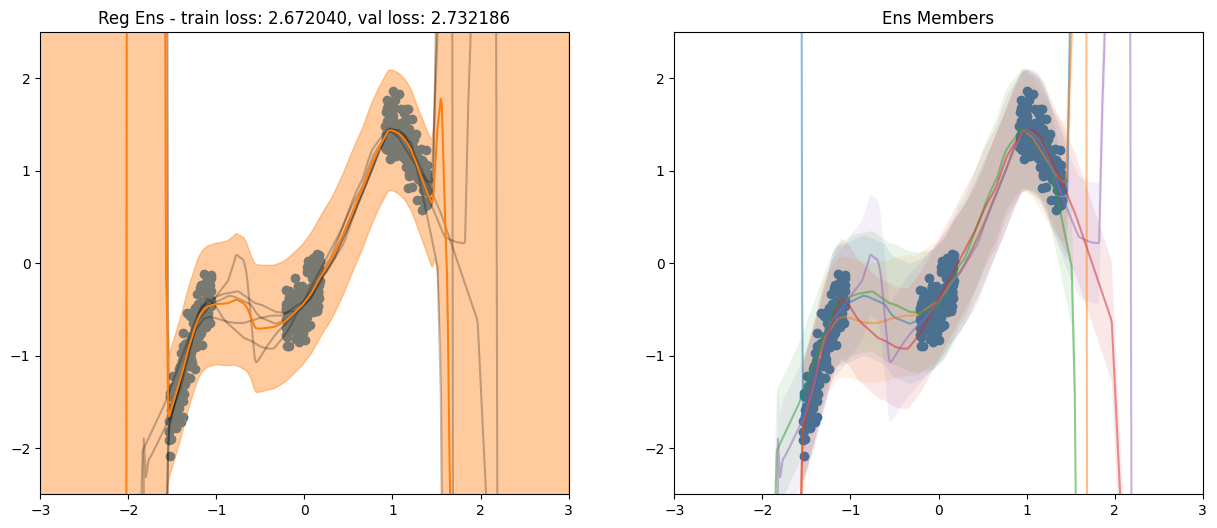

Best val_err
epoch: 131 - train loss: 2.65029, val loss: 2.70897, train err: 0.0316, val err: 0.0412, lr: 0.00010
Best val_err
epoch: 132 - train loss: 2.62855, val loss: 2.68582, train err: 0.0316, val err: 0.0411, lr: 0.00010
Best val_err
epoch: 133 - train loss: 2.60691, val loss: 2.66289, train err: 0.0316, val err: 0.0410, lr: 0.00010
Best val_err
epoch: 134 - train loss: 2.58540, val loss: 2.63983, train err: 0.0316, val err: 0.0408, lr: 0.00010
Best val_err
epoch: 135 - train loss: 2.56395, val loss: 2.61666, train err: 0.0316, val err: 0.0407, lr: 0.00010
Best val_err
epoch: 136 - train loss: 2.54248, val loss: 2.59335, train err: 0.0315, val err: 0.0406, lr: 0.00010
Best val_err
epoch: 137 - train loss: 2.52101, val loss: 2.56989, train err: 0.0315, val err: 0.0405, lr: 0.00010
Best val_err
epoch: 138 - train loss: 2.49961, val loss: 2.54651, train err: 0.0315, val err: 0.0404, lr: 0.00010
Best val_err
epoch: 139 - train loss: 2.47830, val loss: 2.52346, train err: 0.0315, val

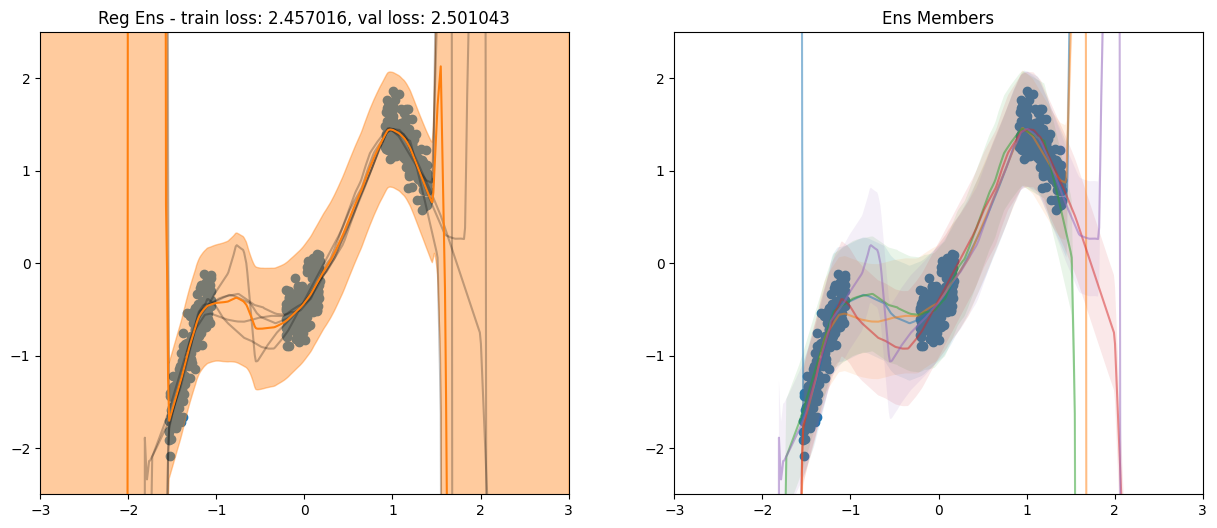

Best val_err
epoch: 141 - train loss: 2.43572, val loss: 2.47925, train err: 0.0315, val err: 0.0401, lr: 0.00010
Best val_err
epoch: 142 - train loss: 2.41443, val loss: 2.45773, train err: 0.0315, val err: 0.0401, lr: 0.00010
Best val_err
epoch: 143 - train loss: 2.39320, val loss: 2.43617, train err: 0.0315, val err: 0.0400, lr: 0.00010
Best val_err
epoch: 144 - train loss: 2.37201, val loss: 2.41465, train err: 0.0314, val err: 0.0400, lr: 0.00010
Best val_err
epoch: 145 - train loss: 2.35084, val loss: 2.39314, train err: 0.0314, val err: 0.0399, lr: 0.00010
Best val_err
epoch: 146 - train loss: 2.32968, val loss: 2.37183, train err: 0.0314, val err: 0.0399, lr: 0.00010
Best val_err
epoch: 147 - train loss: 2.30855, val loss: 2.35083, train err: 0.0314, val err: 0.0398, lr: 0.00010
Best val_err
epoch: 148 - train loss: 2.28745, val loss: 2.32986, train err: 0.0314, val err: 0.0398, lr: 0.00010
Best val_err
epoch: 149 - train loss: 2.26641, val loss: 2.30880, train err: 0.0314, val

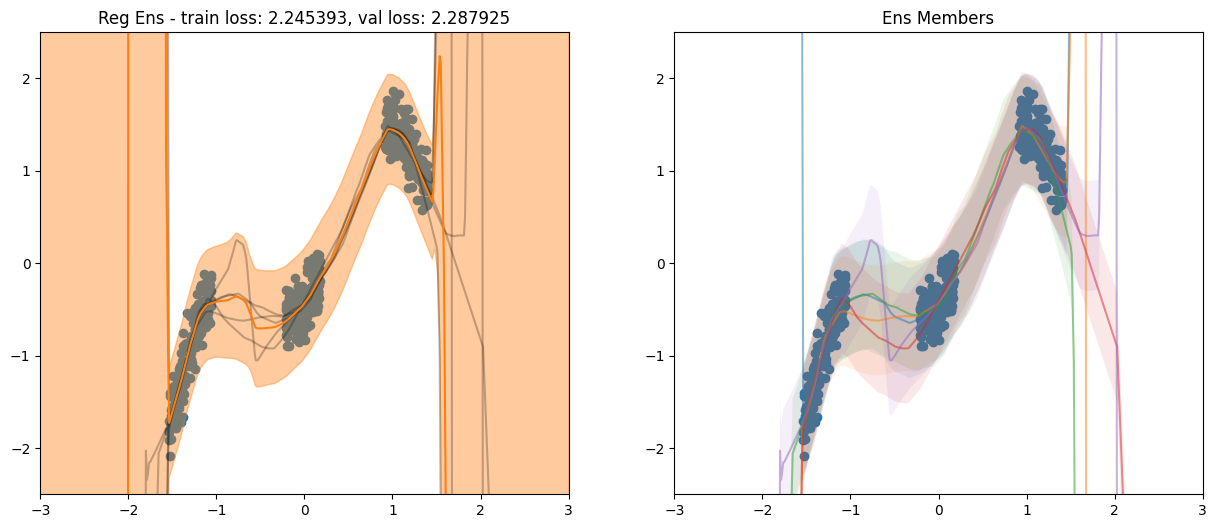

Best val_err
epoch: 151 - train loss: 2.22440, val loss: 2.26737, train err: 0.0314, val err: 0.0396, lr: 0.00010
Best val_err
epoch: 152 - train loss: 2.20346, val loss: 2.24709, train err: 0.0313, val err: 0.0396, lr: 0.00010
Best val_err
epoch: 153 - train loss: 2.18257, val loss: 2.22674, train err: 0.0313, val err: 0.0396, lr: 0.00010
Best val_err
epoch: 154 - train loss: 2.16172, val loss: 2.20606, train err: 0.0313, val err: 0.0395, lr: 0.00010
Best val_err
epoch: 155 - train loss: 2.14090, val loss: 2.18525, train err: 0.0313, val err: 0.0395, lr: 0.00010
Best val_err
epoch: 156 - train loss: 2.12011, val loss: 2.16466, train err: 0.0313, val err: 0.0394, lr: 0.00010
Best val_err
epoch: 157 - train loss: 2.09942, val loss: 2.14449, train err: 0.0313, val err: 0.0394, lr: 0.00010
epoch: 158 - train loss: 2.07871, val loss: 2.12455, train err: 0.0313, val err: 0.0394, lr: 0.00010
epoch: 159 - train loss: 2.05808, val loss: 2.10445, train err: 0.0313, val err: 0.0394, lr: 0.00010


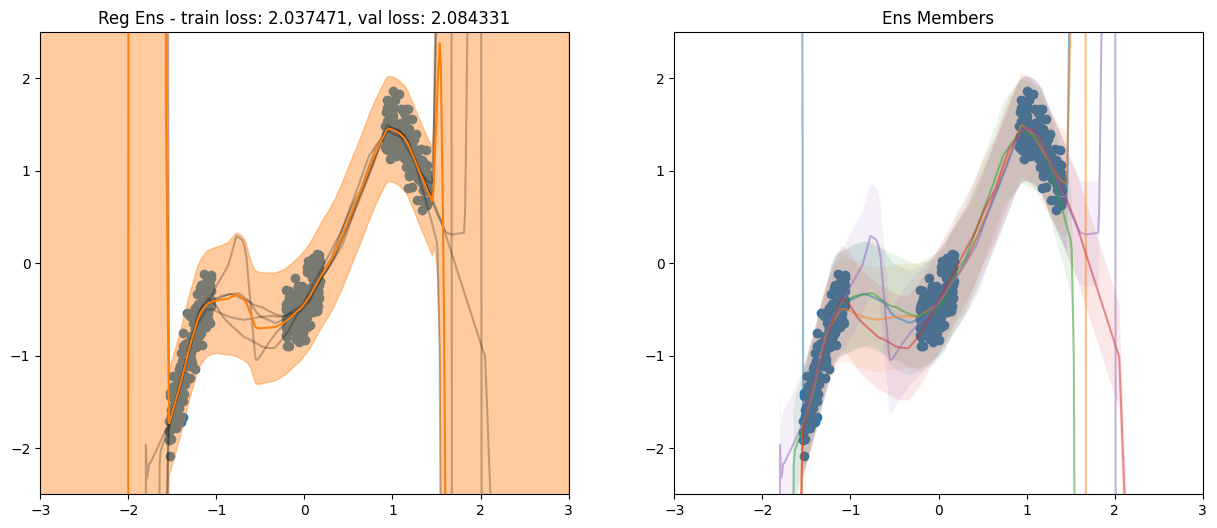

epoch: 161 - train loss: 2.01689, val loss: 2.06437, train err: 0.0313, val err: 0.0394, lr: 0.00010
epoch: 162 - train loss: 1.99635, val loss: 2.04463, train err: 0.0313, val err: 0.0395, lr: 0.00010
epoch: 163 - train loss: 1.97584, val loss: 2.02488, train err: 0.0313, val err: 0.0395, lr: 0.00010
epoch: 164 - train loss: 1.95538, val loss: 2.00487, train err: 0.0313, val err: 0.0395, lr: 0.00010
epoch: 165 - train loss: 1.93498, val loss: 1.98456, train err: 0.0313, val err: 0.0394, lr: 0.00010
epoch: 166 - train loss: 1.91461, val loss: 1.96473, train err: 0.0313, val err: 0.0394, lr: 0.00010
epoch: 167 - train loss: 1.89428, val loss: 1.94546, train err: 0.0312, val err: 0.0395, lr: 0.00010
epoch: 168 - train loss: 1.87397, val loss: 1.92640, train err: 0.0312, val err: 0.0396, lr: 0.00010
epoch: 169 - train loss: 1.85370, val loss: 1.90734, train err: 0.0312, val err: 0.0396, lr: 0.00010
epoch: 170 - train loss: 1.83352, val loss: 1.88781, train err: 0.0312, val err: 0.0396, lr

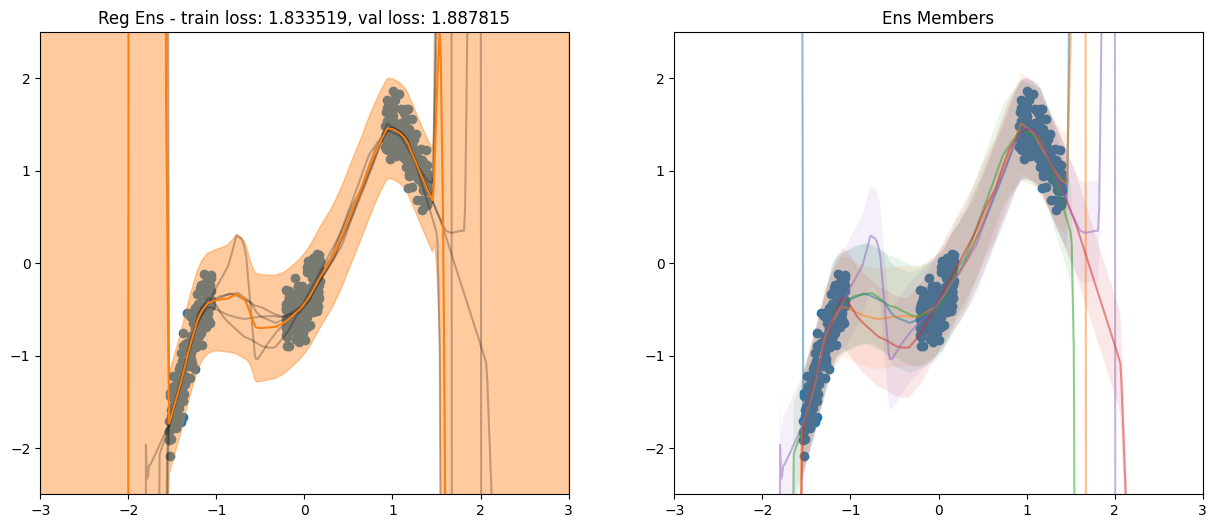

epoch: 171 - train loss: 1.81333, val loss: 1.86819, train err: 0.0312, val err: 0.0396, lr: 0.00010
epoch: 172 - train loss: 1.79320, val loss: 1.84878, train err: 0.0312, val err: 0.0396, lr: 0.00010
epoch: 173 - train loss: 1.77311, val loss: 1.82960, train err: 0.0312, val err: 0.0397, lr: 0.00010
epoch: 174 - train loss: 1.75305, val loss: 1.81031, train err: 0.0312, val err: 0.0397, lr: 0.00010
epoch: 175 - train loss: 1.73304, val loss: 1.79069, train err: 0.0312, val err: 0.0396, lr: 0.00010
epoch: 176 - train loss: 1.71306, val loss: 1.77118, train err: 0.0312, val err: 0.0396, lr: 0.00010
epoch: 177 - train loss: 1.69316, val loss: 1.75182, train err: 0.0312, val err: 0.0396, lr: 0.00010
epoch: 178 - train loss: 1.67317, val loss: 1.73293, train err: 0.0312, val err: 0.0396, lr: 0.00010
epoch: 179 - train loss: 1.65344, val loss: 1.71412, train err: 0.0312, val err: 0.0396, lr: 0.00010
epoch: 180 - train loss: 1.63362, val loss: 1.69568, train err: 0.0312, val err: 0.0396, lr

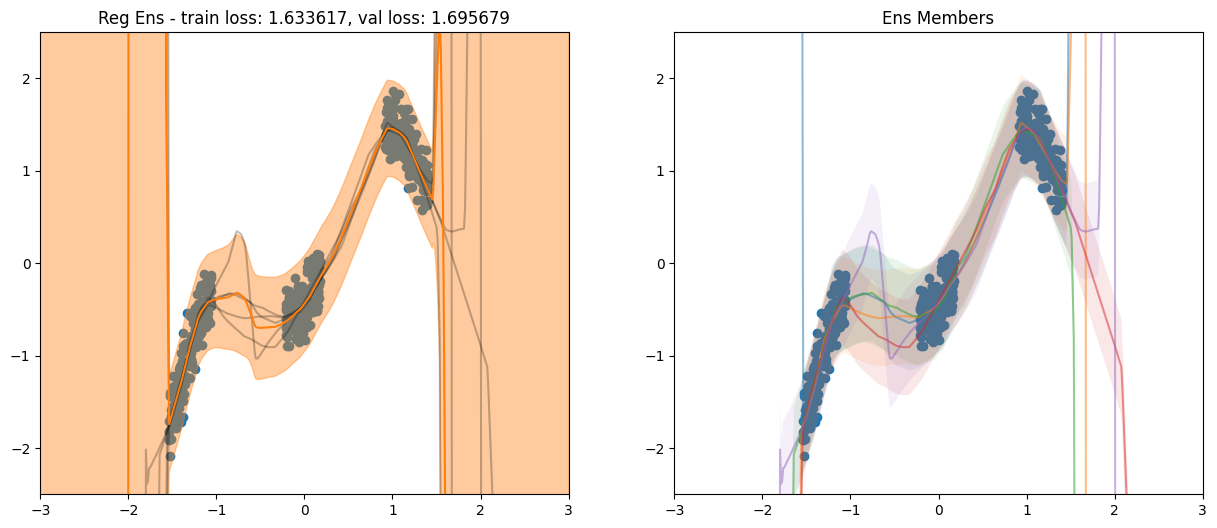

epoch: 181 - train loss: 1.61391, val loss: 1.67625, train err: 0.0312, val err: 0.0396, lr: 0.00010
epoch: 182 - train loss: 1.59413, val loss: 1.65647, train err: 0.0312, val err: 0.0396, lr: 0.00010
epoch: 183 - train loss: 1.57448, val loss: 1.63678, train err: 0.0312, val err: 0.0395, lr: 0.00010
epoch: 184 - train loss: 1.55489, val loss: 1.61789, train err: 0.0312, val err: 0.0395, lr: 0.00010
epoch: 185 - train loss: 1.53540, val loss: 1.59994, train err: 0.0312, val err: 0.0395, lr: 0.00010
epoch: 186 - train loss: 1.51588, val loss: 1.58128, train err: 0.0312, val err: 0.0395, lr: 0.00010
epoch: 187 - train loss: 1.49643, val loss: 1.56185, train err: 0.0312, val err: 0.0394, lr: 0.00010
epoch: 188 - train loss: 1.47697, val loss: 1.54283, train err: 0.0312, val err: 0.0394, lr: 0.00010
epoch: 189 - train loss: 1.45754, val loss: 1.52449, train err: 0.0311, val err: 0.0395, lr: 0.00010
epoch: 190 - train loss: 1.43813, val loss: 1.50627, train err: 0.0311, val err: 0.0395, lr

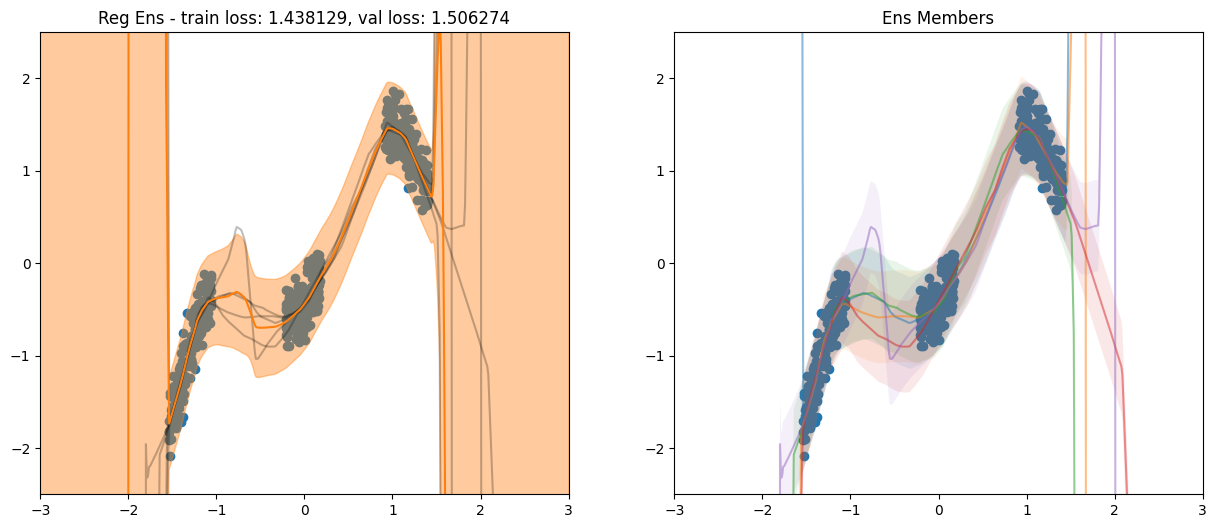

epoch: 191 - train loss: 1.41880, val loss: 1.48721, train err: 0.0311, val err: 0.0394, lr: 0.00010
epoch: 192 - train loss: 1.39947, val loss: 1.46896, train err: 0.0311, val err: 0.0394, lr: 0.00010
Best val_err
epoch: 193 - train loss: 1.38043, val loss: 1.45108, train err: 0.0311, val err: 0.0394, lr: 0.00010
epoch: 194 - train loss: 1.36130, val loss: 1.43369, train err: 0.0311, val err: 0.0395, lr: 0.00010
epoch: 195 - train loss: 1.34218, val loss: 1.41634, train err: 0.0311, val err: 0.0396, lr: 0.00010
epoch: 196 - train loss: 1.32316, val loss: 1.39724, train err: 0.0311, val err: 0.0396, lr: 0.00010
epoch: 197 - train loss: 1.30411, val loss: 1.37781, train err: 0.0311, val err: 0.0395, lr: 0.00010
epoch: 198 - train loss: 1.28504, val loss: 1.35960, train err: 0.0311, val err: 0.0394, lr: 0.00010
epoch: 199 - train loss: 1.26641, val loss: 1.34278, train err: 0.0311, val err: 0.0395, lr: 0.00010
epoch: 200 - train loss: 1.24759, val loss: 1.32629, train err: 0.0311, val er

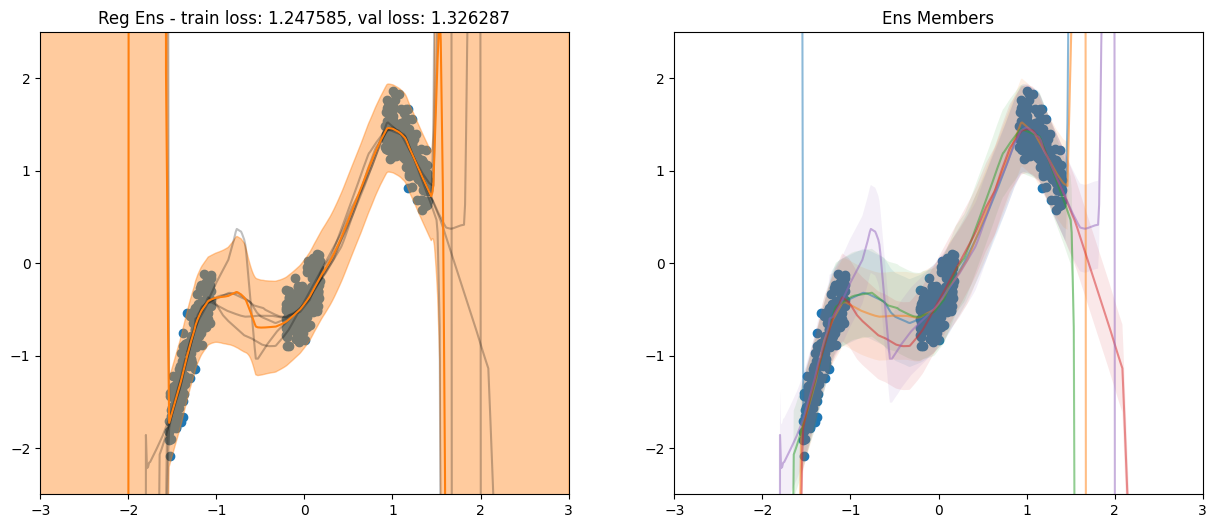

epoch: 201 - train loss: 1.22898, val loss: 1.30696, train err: 0.0311, val err: 0.0395, lr: 0.00010


In [13]:
config = get_reg_ens_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_x = train_dataset[0][0]
init_y = train_dataset[0][1]


best_ens_states = []
for i in range(1):
    rng = random.PRNGKey(i)

    setup_rng, rng = random.split(rng)

    ens_model, state = setup_training(config, setup_rng, init_x, init_y)

    if ENS_RETRAIN:  # RETRAIN
        state, best_state = train_loop(
            ens_model, state, config, rng, make_Reg_Ens_loss, make_Reg_Ens_loss, train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'offline',
                # 'notes': '',
            },
            plot_fn=make_Reg_Ens_plots,
        )

        best_ens_states.append(best_state)

        save_checkpoint(f'dynNN_results/ens_model_{i}_presentation', best_state, 1, overwrite=True)

In [9]:
# if ENS_RETRAIN:  # RETRAIN
#     save_checkpoint('dynNN_results/ens_models', best_ens_states, 1, overwrite=True)

## PoN

In [10]:
config = get_pon_config()
config.model_name

'PoN_Ens'

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

2022-12-13 17:06:47.618343: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-13 17:06:48.141584: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-13 17:06:48.141650: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-13 17:06:48.141658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


  0%|          | 0/201 [00:00<?, ?it/s]

epoch:   1 - train loss: 1.24774, val loss: 1.47956, train err: 0.6576, val err: 1.1212, lr: 0.00010
Best val_err
epoch:   2 - train loss: 1.21551, val loss: 1.48059, train err: 0.5932, val err: 1.1233, lr: 0.00010
epoch:   3 - train loss: 1.20763, val loss: 1.48105, train err: 0.5775, val err: 1.1242, lr: 0.00010
epoch:   4 - train loss: 1.20230, val loss: 1.48103, train err: 0.5669, val err: 1.1241, lr: 0.00010
epoch:   5 - train loss: 1.19556, val loss: 1.48046, train err: 0.5536, val err: 1.1229, lr: 0.00010
epoch:   6 - train loss: 1.18800, val loss: 1.47929, train err: 0.5386, val err: 1.1205, lr: 0.00010
Best val_err
epoch:   7 - train loss: 1.17957, val loss: 1.47758, train err: 0.5219, val err: 1.1171, lr: 0.00010
Best val_err
epoch:   8 - train loss: 1.16998, val loss: 1.47509, train err: 0.5030, val err: 1.1120, lr: 0.00010
Best val_err
epoch:   9 - train loss: 1.16010, val loss: 1.47200, train err: 0.4836, val err: 1.1058, lr: 0.00010
Best val_err
epoch:  10 - train loss: 1

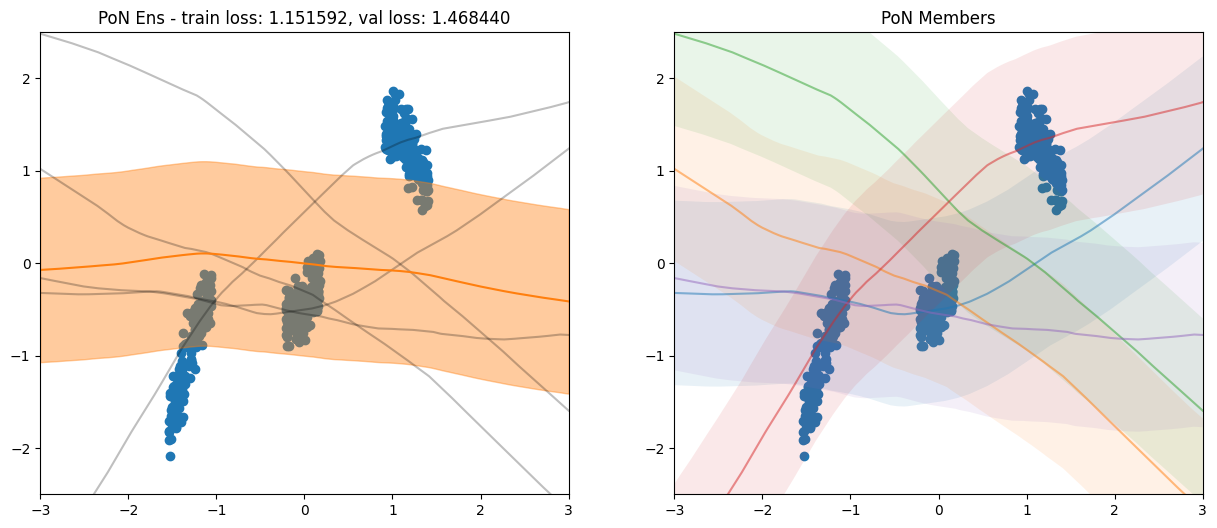

Best val_err
epoch:  11 - train loss: 1.14304, val loss: 1.46429, train err: 0.4502, val err: 1.0903, lr: 0.00010
Best val_err
epoch:  12 - train loss: 1.13449, val loss: 1.45947, train err: 0.4335, val err: 1.0807, lr: 0.00010
Best val_err
epoch:  13 - train loss: 1.12603, val loss: 1.45402, train err: 0.4171, val err: 1.0697, lr: 0.00010
Best val_err
epoch:  14 - train loss: 1.11774, val loss: 1.44816, train err: 0.4010, val err: 1.0580, lr: 0.00010
Best val_err
epoch:  15 - train loss: 1.10964, val loss: 1.44181, train err: 0.3854, val err: 1.0454, lr: 0.00010
Best val_err
epoch:  16 - train loss: 1.10174, val loss: 1.43481, train err: 0.3702, val err: 1.0314, lr: 0.00010
Best val_err
epoch:  17 - train loss: 1.09410, val loss: 1.42694, train err: 0.3556, val err: 1.0158, lr: 0.00010
Best val_err
epoch:  18 - train loss: 1.08674, val loss: 1.41823, train err: 0.3416, val err: 0.9985, lr: 0.00010
Best val_err
epoch:  19 - train loss: 1.07962, val loss: 1.40854, train err: 0.3281, val

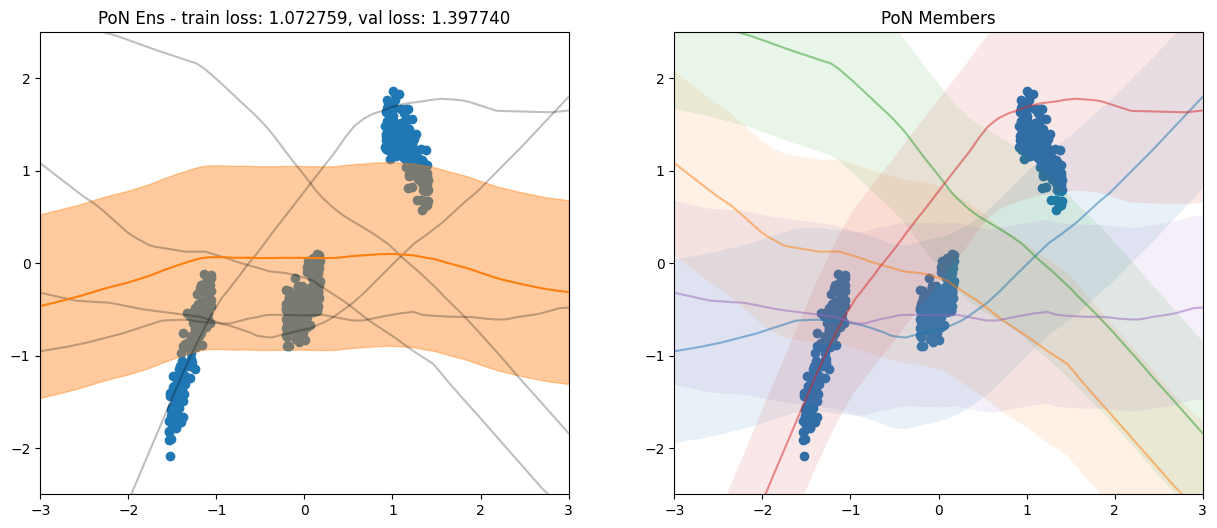

Best val_err
epoch:  21 - train loss: 1.06618, val loss: 1.38621, train err: 0.3029, val err: 0.9353, lr: 0.00010
Best val_err
epoch:  22 - train loss: 1.05989, val loss: 1.37396, train err: 0.2912, val err: 0.9112, lr: 0.00010
Best val_err
epoch:  23 - train loss: 1.05385, val loss: 1.36112, train err: 0.2801, val err: 0.8860, lr: 0.00010
Best val_err
epoch:  24 - train loss: 1.04810, val loss: 1.34779, train err: 0.2696, val err: 0.8599, lr: 0.00010
Best val_err
epoch:  25 - train loss: 1.04265, val loss: 1.33410, train err: 0.2597, val err: 0.8332, lr: 0.00010
Best val_err
epoch:  26 - train loss: 1.03740, val loss: 1.32003, train err: 0.2502, val err: 0.8057, lr: 0.00010
Best val_err
epoch:  27 - train loss: 1.03239, val loss: 1.30555, train err: 0.2413, val err: 0.7776, lr: 0.00010
Best val_err
epoch:  28 - train loss: 1.02764, val loss: 1.29084, train err: 0.2329, val err: 0.7490, lr: 0.00010
Best val_err
epoch:  29 - train loss: 1.02315, val loss: 1.27629, train err: 0.2251, val

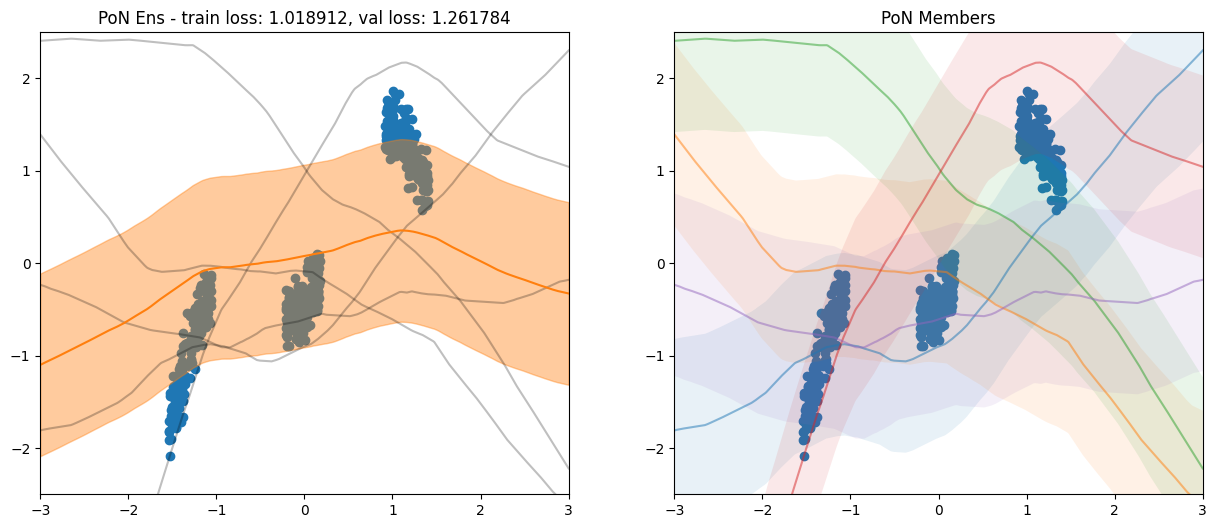

Best val_err
epoch:  31 - train loss: 1.01487, val loss: 1.24728, train err: 0.2109, val err: 0.6650, lr: 0.00010
Best val_err
epoch:  32 - train loss: 1.01099, val loss: 1.23279, train err: 0.2044, val err: 0.6372, lr: 0.00010
Best val_err
epoch:  33 - train loss: 1.00728, val loss: 1.21844, train err: 0.1982, val err: 0.6098, lr: 0.00010
Best val_err
epoch:  34 - train loss: 1.00371, val loss: 1.20426, train err: 0.1923, val err: 0.5828, lr: 0.00010
Best val_err
epoch:  35 - train loss: 1.00029, val loss: 1.19028, train err: 0.1868, val err: 0.5563, lr: 0.00010
Best val_err
epoch:  36 - train loss: 0.99700, val loss: 1.17666, train err: 0.1816, val err: 0.5305, lr: 0.00010
Best val_err
epoch:  37 - train loss: 0.99383, val loss: 1.16354, train err: 0.1766, val err: 0.5058, lr: 0.00010
Best val_err
epoch:  38 - train loss: 0.99076, val loss: 1.15092, train err: 0.1718, val err: 0.4821, lr: 0.00010
Best val_err
epoch:  39 - train loss: 0.98780, val loss: 1.13871, train err: 0.1673, val

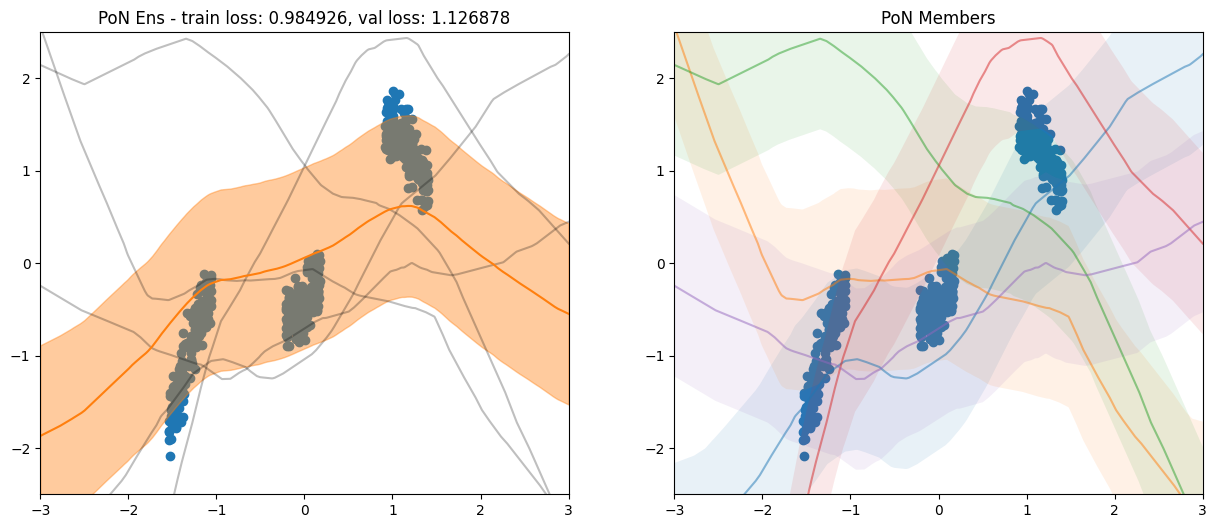

Best val_err
epoch:  41 - train loss: 0.98211, val loss: 1.11546, train err: 0.1587, val err: 0.4162, lr: 0.00010
Best val_err
epoch:  42 - train loss: 0.97935, val loss: 1.10451, train err: 0.1547, val err: 0.3960, lr: 0.00010
Best val_err
epoch:  43 - train loss: 0.97664, val loss: 1.09394, train err: 0.1507, val err: 0.3766, lr: 0.00010
Best val_err
epoch:  44 - train loss: 0.97395, val loss: 1.08391, train err: 0.1468, val err: 0.3584, lr: 0.00010
Best val_err
epoch:  45 - train loss: 0.97132, val loss: 1.07435, train err: 0.1431, val err: 0.3411, lr: 0.00010
Best val_err
epoch:  46 - train loss: 0.96879, val loss: 1.06517, train err: 0.1395, val err: 0.3246, lr: 0.00010
Best val_err
epoch:  47 - train loss: 0.96629, val loss: 1.05638, train err: 0.1361, val err: 0.3088, lr: 0.00010
Best val_err
epoch:  48 - train loss: 0.96366, val loss: 1.04798, train err: 0.1324, val err: 0.2939, lr: 0.00010
Best val_err
epoch:  49 - train loss: 0.96094, val loss: 1.04010, train err: 0.1285, val

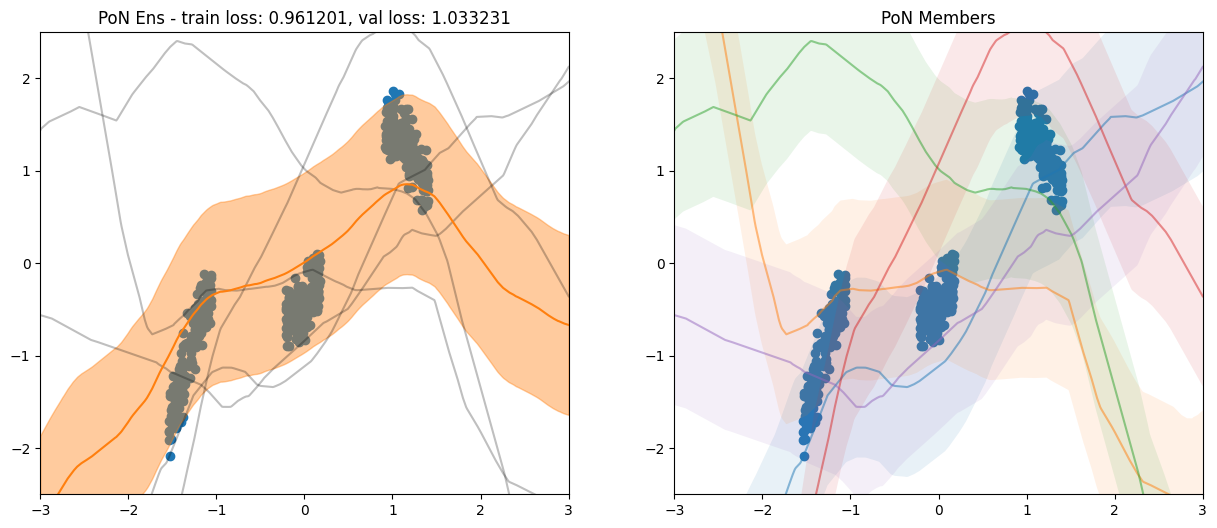

Best val_err
epoch:  51 - train loss: 0.95916, val loss: 1.02634, train err: 0.1279, val err: 0.2562, lr: 0.00010
Best val_err
epoch:  52 - train loss: 0.95711, val loss: 1.01959, train err: 0.1253, val err: 0.2446, lr: 0.00010
Best val_err
epoch:  53 - train loss: 0.95507, val loss: 1.01312, train err: 0.1229, val err: 0.2336, lr: 0.00010
Best val_err
epoch:  54 - train loss: 0.95307, val loss: 1.00703, train err: 0.1204, val err: 0.2233, lr: 0.00010
Best val_err
epoch:  55 - train loss: 0.95110, val loss: 1.00132, train err: 0.1181, val err: 0.2138, lr: 0.00010
Best val_err
epoch:  56 - train loss: 0.94917, val loss: 0.99588, train err: 0.1159, val err: 0.2048, lr: 0.00010
Best val_err
epoch:  57 - train loss: 0.94725, val loss: 0.99082, train err: 0.1137, val err: 0.1966, lr: 0.00010
Best val_err
epoch:  58 - train loss: 0.94538, val loss: 0.98616, train err: 0.1116, val err: 0.1892, lr: 0.00010
Best val_err
epoch:  59 - train loss: 0.94358, val loss: 0.98189, train err: 0.1096, val

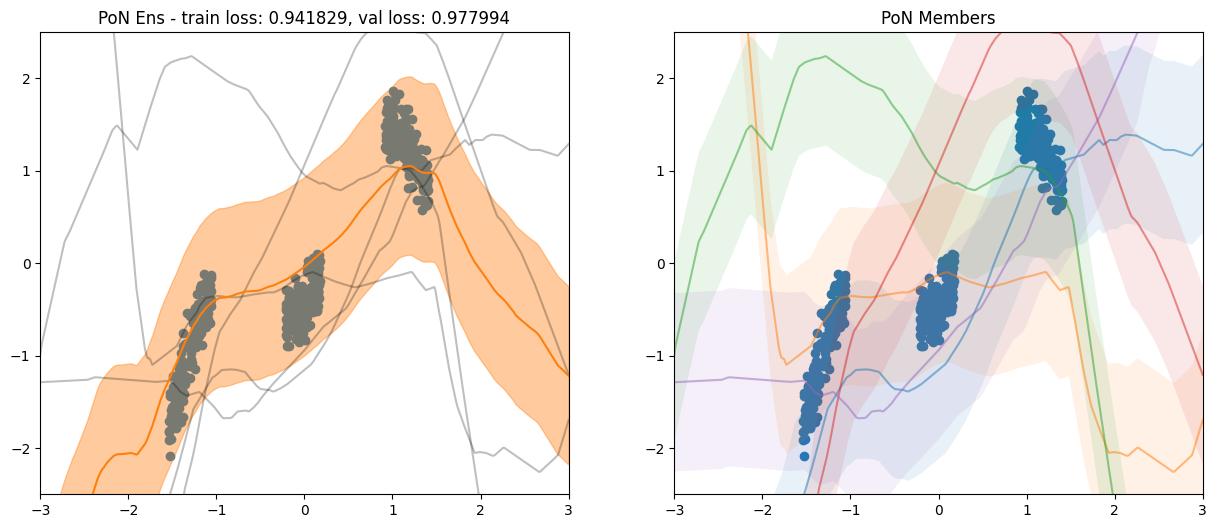

Best val_err
epoch:  61 - train loss: 0.94011, val loss: 0.97442, train err: 0.1060, val err: 0.1711, lr: 0.00010
Best val_err
epoch:  62 - train loss: 0.93840, val loss: 0.97112, train err: 0.1042, val err: 0.1663, lr: 0.00010
Best val_err
epoch:  63 - train loss: 0.93669, val loss: 0.96810, train err: 0.1024, val err: 0.1620, lr: 0.00010
Best val_err
epoch:  64 - train loss: 0.93499, val loss: 0.96530, train err: 0.1007, val err: 0.1582, lr: 0.00010
Best val_err
epoch:  65 - train loss: 0.93332, val loss: 0.96264, train err: 0.0991, val err: 0.1546, lr: 0.00010
Best val_err
epoch:  66 - train loss: 0.93167, val loss: 0.96016, train err: 0.0975, val err: 0.1514, lr: 0.00010
Best val_err
epoch:  67 - train loss: 0.93006, val loss: 0.95783, train err: 0.0959, val err: 0.1485, lr: 0.00010
Best val_err
epoch:  68 - train loss: 0.92846, val loss: 0.95566, train err: 0.0944, val err: 0.1458, lr: 0.00010
Best val_err
epoch:  69 - train loss: 0.92688, val loss: 0.95361, train err: 0.0930, val

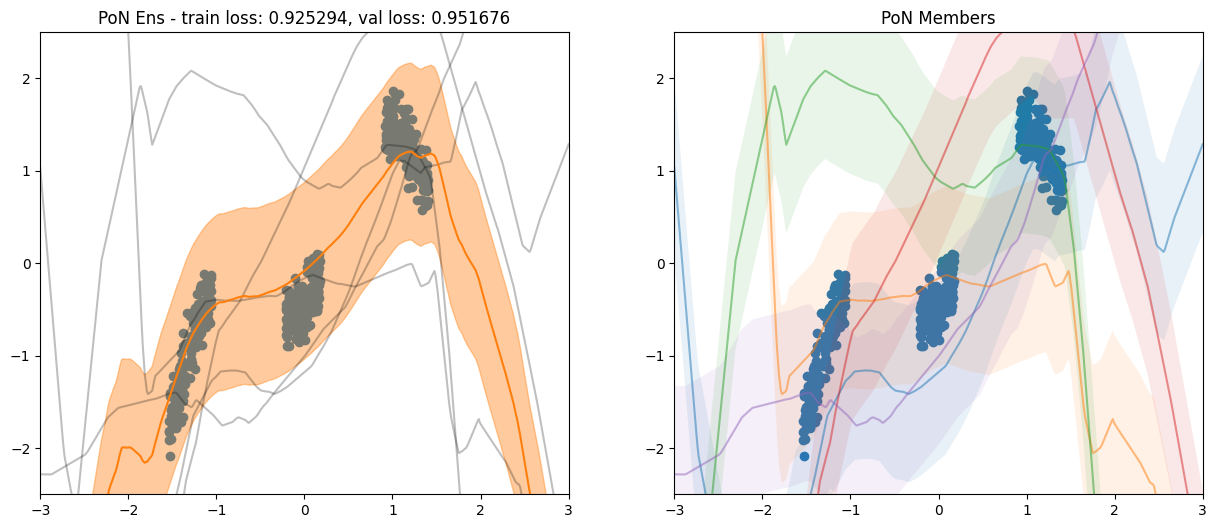

Best val_err
epoch:  71 - train loss: 0.92375, val loss: 0.94982, train err: 0.0901, val err: 0.1392, lr: 0.00010
Best val_err
epoch:  72 - train loss: 0.92224, val loss: 0.94800, train err: 0.0888, val err: 0.1373, lr: 0.00010
Best val_err
epoch:  73 - train loss: 0.92076, val loss: 0.94623, train err: 0.0876, val err: 0.1354, lr: 0.00010
Best val_err
epoch:  74 - train loss: 0.91929, val loss: 0.94448, train err: 0.0864, val err: 0.1336, lr: 0.00010
Best val_err
epoch:  75 - train loss: 0.91784, val loss: 0.94275, train err: 0.0852, val err: 0.1319, lr: 0.00010
Best val_err
epoch:  76 - train loss: 0.91642, val loss: 0.94101, train err: 0.0841, val err: 0.1301, lr: 0.00010
Best val_err
epoch:  77 - train loss: 0.91501, val loss: 0.93935, train err: 0.0830, val err: 0.1285, lr: 0.00010
Best val_err
epoch:  78 - train loss: 0.91362, val loss: 0.93777, train err: 0.0820, val err: 0.1270, lr: 0.00010
Best val_err
epoch:  79 - train loss: 0.91225, val loss: 0.93627, train err: 0.0810, val

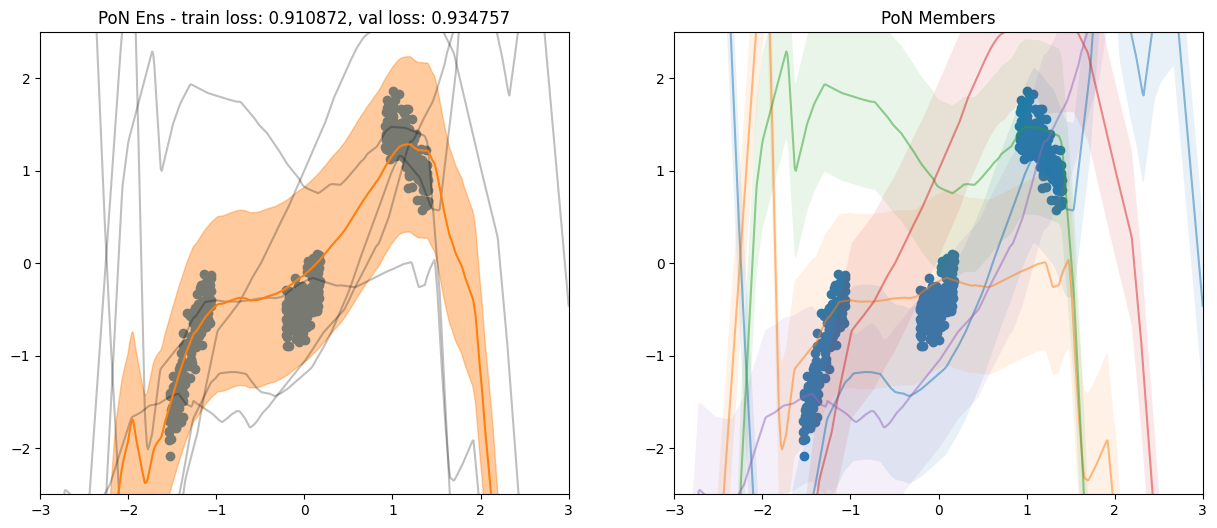

Best val_err
epoch:  81 - train loss: 0.90951, val loss: 0.93319, train err: 0.0790, val err: 0.1229, lr: 0.00010
Best val_err
epoch:  82 - train loss: 0.90815, val loss: 0.93163, train err: 0.0780, val err: 0.1215, lr: 0.00010
Best val_err
epoch:  83 - train loss: 0.90682, val loss: 0.93003, train err: 0.0771, val err: 0.1201, lr: 0.00010
Best val_err
epoch:  84 - train loss: 0.90551, val loss: 0.92843, train err: 0.0762, val err: 0.1186, lr: 0.00010
Best val_err
epoch:  85 - train loss: 0.90421, val loss: 0.92684, train err: 0.0754, val err: 0.1172, lr: 0.00010
Best val_err
epoch:  86 - train loss: 0.90292, val loss: 0.92525, train err: 0.0746, val err: 0.1157, lr: 0.00010
Best val_err
epoch:  87 - train loss: 0.90163, val loss: 0.92369, train err: 0.0737, val err: 0.1144, lr: 0.00010
Best val_err
epoch:  88 - train loss: 0.90034, val loss: 0.92211, train err: 0.0729, val err: 0.1130, lr: 0.00010
Best val_err
epoch:  89 - train loss: 0.89906, val loss: 0.92055, train err: 0.0721, val

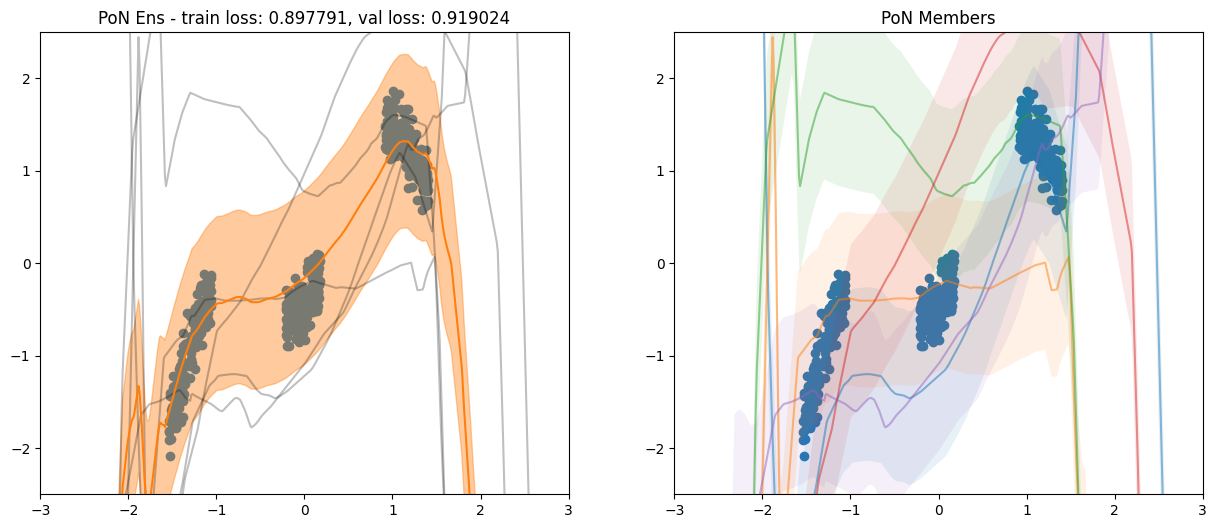

Best val_err
epoch:  91 - train loss: 0.89654, val loss: 0.91751, train err: 0.0706, val err: 0.1091, lr: 0.00010
Best val_err
epoch:  92 - train loss: 0.89528, val loss: 0.91600, train err: 0.0699, val err: 0.1078, lr: 0.00010
Best val_err
epoch:  93 - train loss: 0.89404, val loss: 0.91450, train err: 0.0692, val err: 0.1066, lr: 0.00010
Best val_err
epoch:  94 - train loss: 0.89280, val loss: 0.91305, train err: 0.0685, val err: 0.1054, lr: 0.00010
Best val_err
epoch:  95 - train loss: 0.89156, val loss: 0.91162, train err: 0.0678, val err: 0.1044, lr: 0.00010
Best val_err
epoch:  96 - train loss: 0.89033, val loss: 0.91021, train err: 0.0671, val err: 0.1033, lr: 0.00010
Best val_err
epoch:  97 - train loss: 0.88910, val loss: 0.90883, train err: 0.0665, val err: 0.1023, lr: 0.00010
Best val_err
epoch:  98 - train loss: 0.88789, val loss: 0.90748, train err: 0.0658, val err: 0.1014, lr: 0.00010
Best val_err
epoch:  99 - train loss: 0.88668, val loss: 0.90613, train err: 0.0652, val

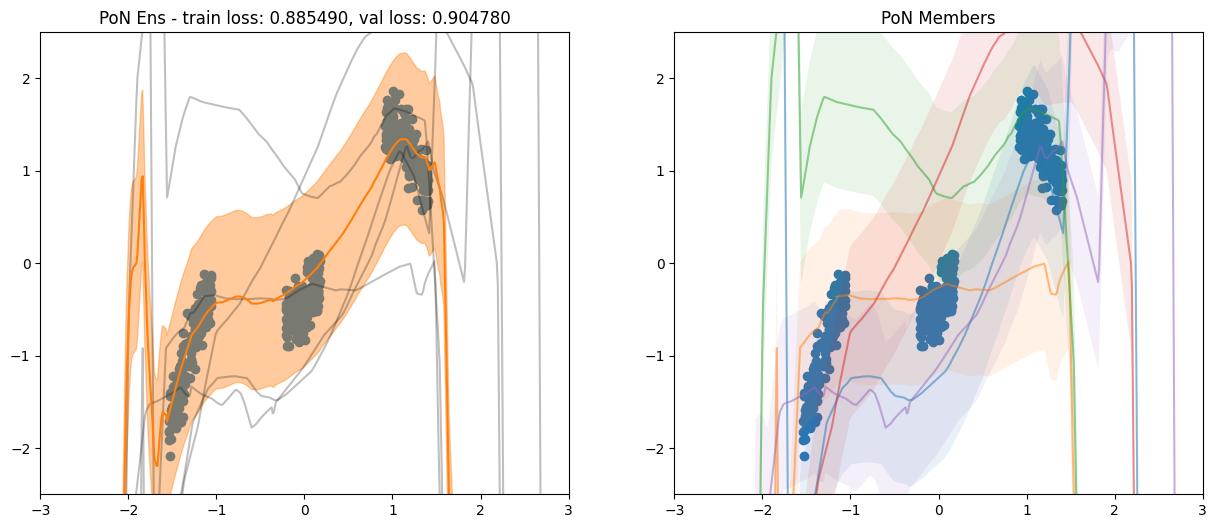

Best val_err
epoch: 101 - train loss: 0.88430, val loss: 0.90343, train err: 0.0640, val err: 0.0986, lr: 0.00010
Best val_err
epoch: 102 - train loss: 0.88313, val loss: 0.90206, train err: 0.0634, val err: 0.0976, lr: 0.00010
Best val_err
epoch: 103 - train loss: 0.88196, val loss: 0.90069, train err: 0.0629, val err: 0.0967, lr: 0.00010
Best val_err
epoch: 104 - train loss: 0.88080, val loss: 0.89931, train err: 0.0624, val err: 0.0957, lr: 0.00010
Best val_err
epoch: 105 - train loss: 0.87965, val loss: 0.89795, train err: 0.0619, val err: 0.0948, lr: 0.00010
Best val_err
epoch: 106 - train loss: 0.87851, val loss: 0.89660, train err: 0.0614, val err: 0.0939, lr: 0.00010
Best val_err
epoch: 107 - train loss: 0.87737, val loss: 0.89526, train err: 0.0609, val err: 0.0930, lr: 0.00010
Best val_err
epoch: 108 - train loss: 0.87624, val loss: 0.89393, train err: 0.0604, val err: 0.0921, lr: 0.00010
Best val_err
epoch: 109 - train loss: 0.87512, val loss: 0.89261, train err: 0.0600, val

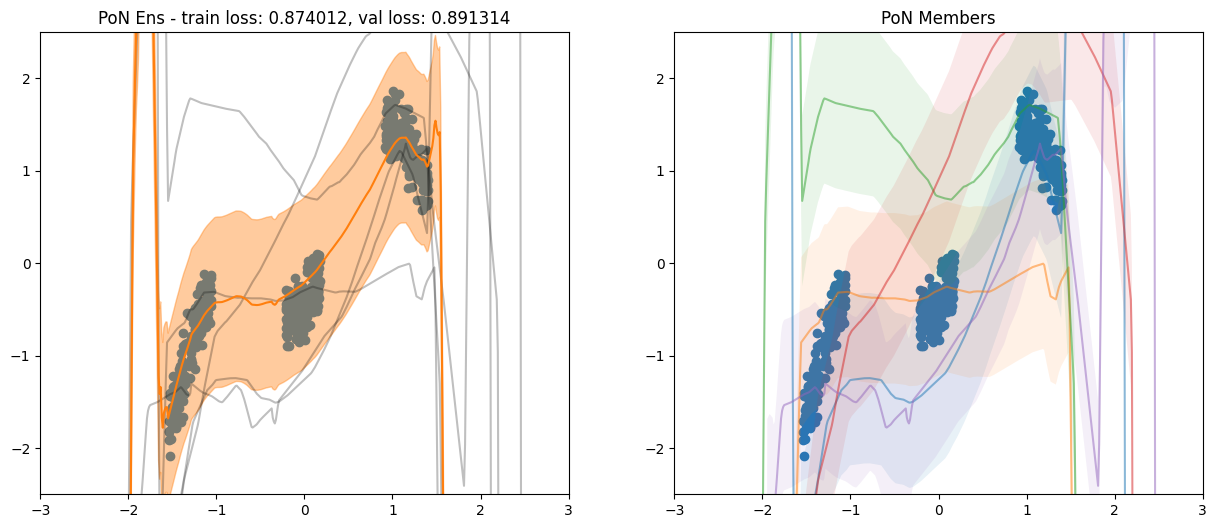

Best val_err
epoch: 111 - train loss: 0.87290, val loss: 0.89004, train err: 0.0591, val err: 0.0897, lr: 0.00010
Best val_err
epoch: 112 - train loss: 0.87180, val loss: 0.88879, train err: 0.0587, val err: 0.0890, lr: 0.00010
Best val_err
epoch: 113 - train loss: 0.87069, val loss: 0.88755, train err: 0.0583, val err: 0.0883, lr: 0.00010
Best val_err
epoch: 114 - train loss: 0.86960, val loss: 0.88633, train err: 0.0579, val err: 0.0876, lr: 0.00010
Best val_err
epoch: 115 - train loss: 0.86850, val loss: 0.88512, train err: 0.0575, val err: 0.0870, lr: 0.00010
Best val_err
epoch: 116 - train loss: 0.86741, val loss: 0.88393, train err: 0.0571, val err: 0.0864, lr: 0.00010
Best val_err
epoch: 117 - train loss: 0.86632, val loss: 0.88274, train err: 0.0568, val err: 0.0858, lr: 0.00010
Best val_err
epoch: 118 - train loss: 0.86523, val loss: 0.88154, train err: 0.0564, val err: 0.0852, lr: 0.00010
Best val_err
epoch: 119 - train loss: 0.86415, val loss: 0.88035, train err: 0.0560, val

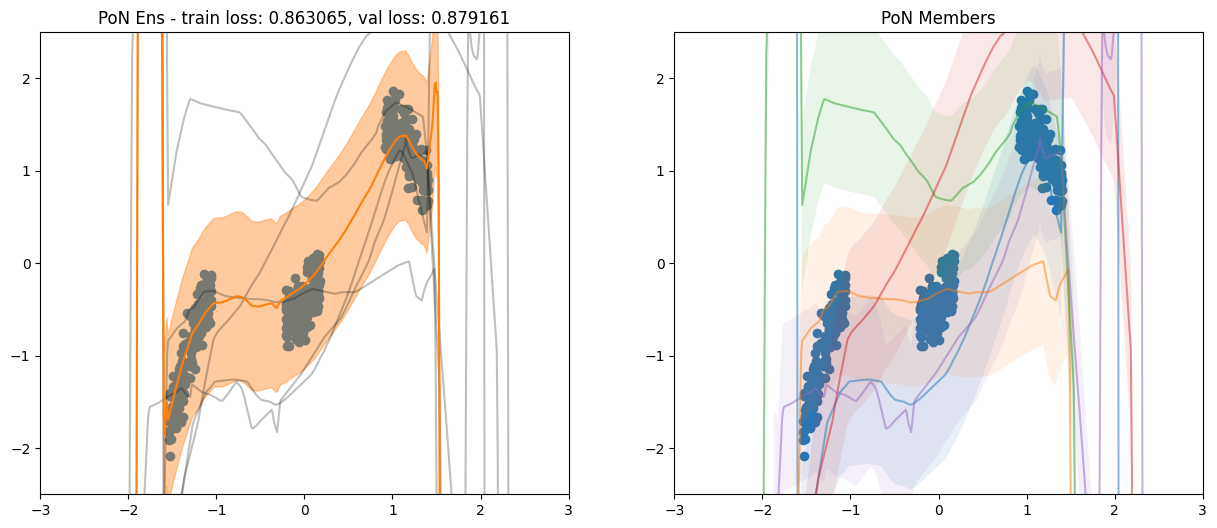

Best val_err
epoch: 121 - train loss: 0.86198, val loss: 0.87798, train err: 0.0553, val err: 0.0834, lr: 0.00010
Best val_err
epoch: 122 - train loss: 0.86091, val loss: 0.87681, train err: 0.0550, val err: 0.0829, lr: 0.00010
Best val_err
epoch: 123 - train loss: 0.85983, val loss: 0.87563, train err: 0.0546, val err: 0.0823, lr: 0.00010
Best val_err
epoch: 124 - train loss: 0.85876, val loss: 0.87448, train err: 0.0543, val err: 0.0818, lr: 0.00010
Best val_err
epoch: 125 - train loss: 0.85770, val loss: 0.87339, train err: 0.0540, val err: 0.0814, lr: 0.00010
Best val_err
epoch: 126 - train loss: 0.85663, val loss: 0.87231, train err: 0.0536, val err: 0.0810, lr: 0.00010
Best val_err
epoch: 127 - train loss: 0.85556, val loss: 0.87126, train err: 0.0533, val err: 0.0806, lr: 0.00010
Best val_err
epoch: 128 - train loss: 0.85450, val loss: 0.87022, train err: 0.0530, val err: 0.0803, lr: 0.00010
Best val_err
epoch: 129 - train loss: 0.85344, val loss: 0.86921, train err: 0.0527, val

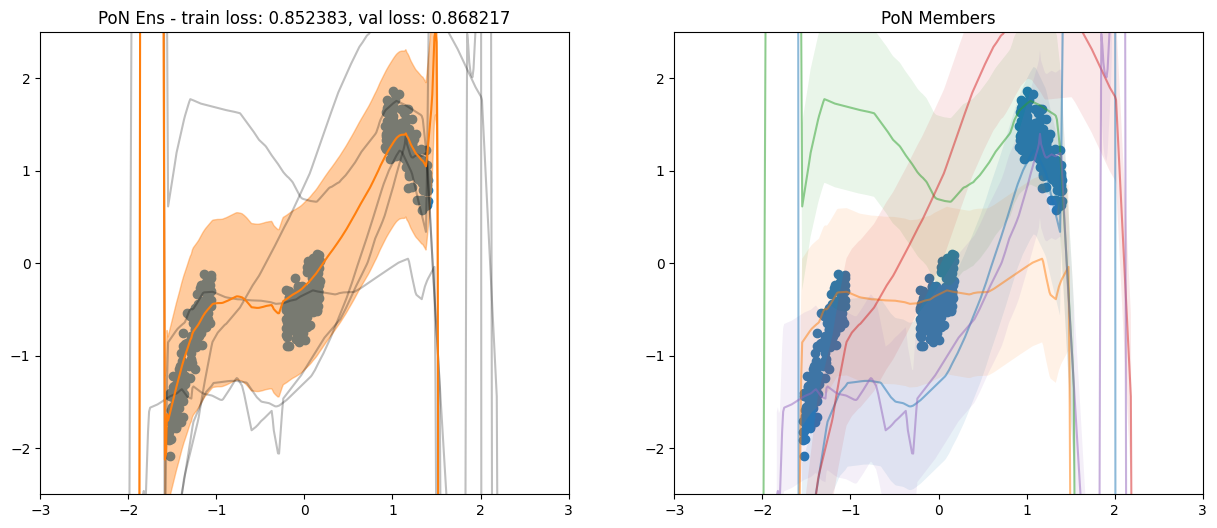

Best val_err
epoch: 131 - train loss: 0.85133, val loss: 0.86716, train err: 0.0521, val err: 0.0794, lr: 0.00010
Best val_err
epoch: 132 - train loss: 0.85028, val loss: 0.86604, train err: 0.0518, val err: 0.0790, lr: 0.00010
Best val_err
epoch: 133 - train loss: 0.84923, val loss: 0.86487, train err: 0.0515, val err: 0.0785, lr: 0.00010
Best val_err
epoch: 134 - train loss: 0.84818, val loss: 0.86372, train err: 0.0512, val err: 0.0779, lr: 0.00010
Best val_err
epoch: 135 - train loss: 0.84713, val loss: 0.86260, train err: 0.0510, val err: 0.0775, lr: 0.00010
Best val_err
epoch: 136 - train loss: 0.84608, val loss: 0.86151, train err: 0.0507, val err: 0.0771, lr: 0.00010
Best val_err
epoch: 137 - train loss: 0.84504, val loss: 0.86044, train err: 0.0504, val err: 0.0768, lr: 0.00010
Best val_err
epoch: 138 - train loss: 0.84401, val loss: 0.85939, train err: 0.0502, val err: 0.0764, lr: 0.00010
Best val_err
epoch: 139 - train loss: 0.84297, val loss: 0.85835, train err: 0.0499, val

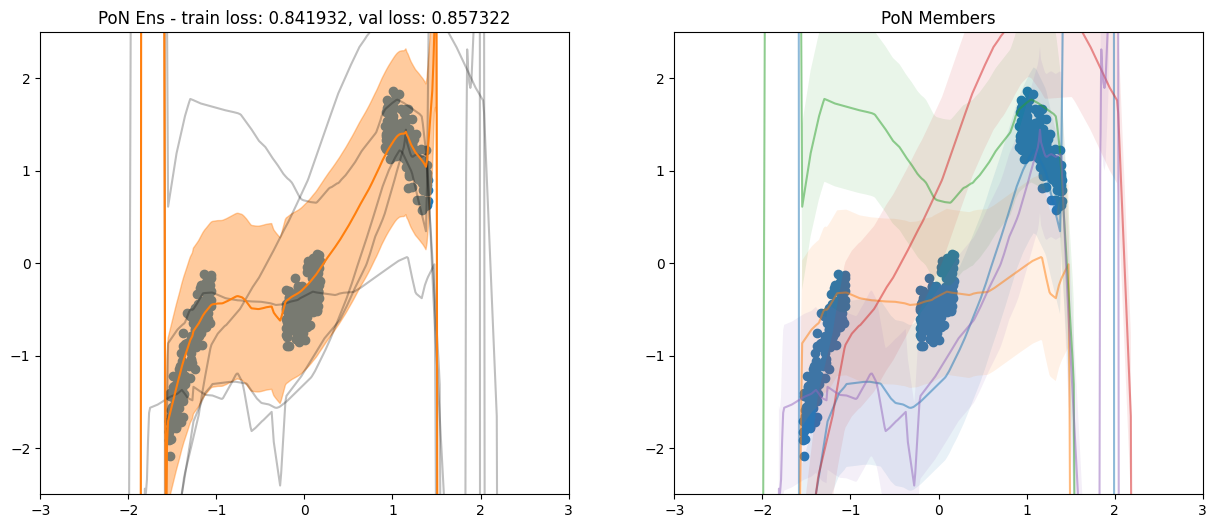

Best val_err
epoch: 141 - train loss: 0.84090, val loss: 0.85631, train err: 0.0494, val err: 0.0756, lr: 0.00010
Best val_err
epoch: 142 - train loss: 0.83986, val loss: 0.85527, train err: 0.0491, val err: 0.0752, lr: 0.00010
Best val_err
epoch: 143 - train loss: 0.83883, val loss: 0.85421, train err: 0.0489, val err: 0.0749, lr: 0.00010
Best val_err
epoch: 144 - train loss: 0.83780, val loss: 0.85312, train err: 0.0487, val err: 0.0745, lr: 0.00010
Best val_err
epoch: 145 - train loss: 0.83677, val loss: 0.85199, train err: 0.0484, val err: 0.0741, lr: 0.00010
Best val_err
epoch: 146 - train loss: 0.83575, val loss: 0.85091, train err: 0.0482, val err: 0.0737, lr: 0.00010
Best val_err
epoch: 147 - train loss: 0.83472, val loss: 0.84984, train err: 0.0480, val err: 0.0734, lr: 0.00010
Best val_err
epoch: 148 - train loss: 0.83370, val loss: 0.84876, train err: 0.0477, val err: 0.0730, lr: 0.00010
Best val_err
epoch: 149 - train loss: 0.83267, val loss: 0.84766, train err: 0.0475, val

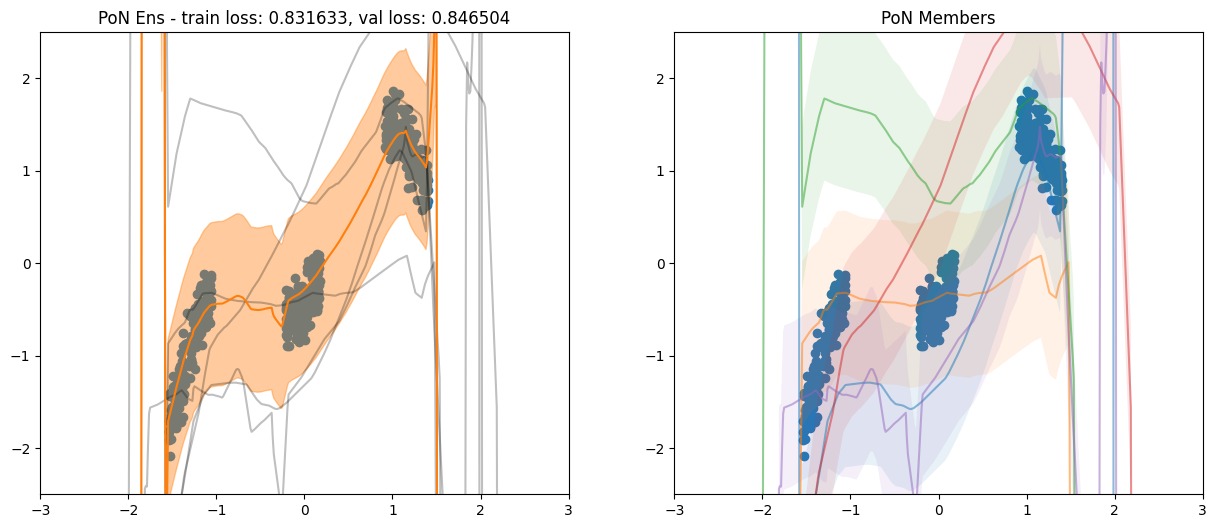

Best val_err
epoch: 151 - train loss: 0.83058, val loss: 0.84478, train err: 0.0470, val err: 0.0708, lr: 0.00010
Best val_err
epoch: 152 - train loss: 0.82947, val loss: 0.84226, train err: 0.0466, val err: 0.0681, lr: 0.00010
Best val_err
epoch: 153 - train loss: 0.82824, val loss: 0.83975, train err: 0.0461, val err: 0.0656, lr: 0.00010
Best val_err
epoch: 154 - train loss: 0.82708, val loss: 0.83829, train err: 0.0457, val err: 0.0646, lr: 0.00010
Best val_err
epoch: 155 - train loss: 0.82600, val loss: 0.83710, train err: 0.0454, val err: 0.0641, lr: 0.00010
Best val_err
epoch: 156 - train loss: 0.82498, val loss: 0.83550, train err: 0.0451, val err: 0.0629, lr: 0.00010
Best val_err
epoch: 157 - train loss: 0.82394, val loss: 0.83402, train err: 0.0449, val err: 0.0620, lr: 0.00010
Best val_err
epoch: 158 - train loss: 0.82286, val loss: 0.83256, train err: 0.0446, val err: 0.0611, lr: 0.00010
Best val_err
epoch: 159 - train loss: 0.82179, val loss: 0.83130, train err: 0.0443, val

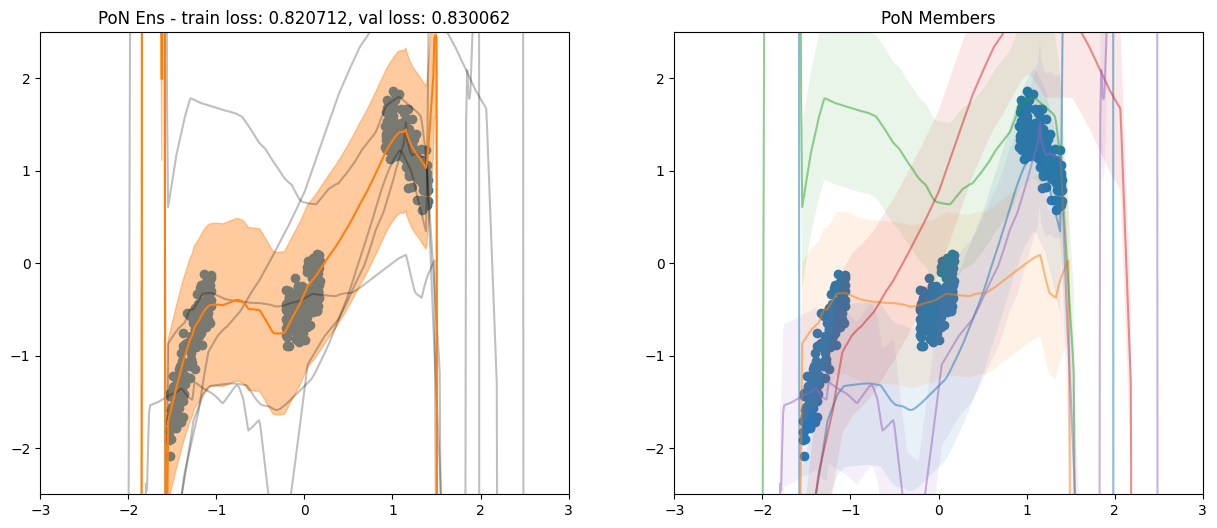

Best val_err
epoch: 161 - train loss: 0.81965, val loss: 0.82894, train err: 0.0437, val err: 0.0595, lr: 0.00010
Best val_err
epoch: 162 - train loss: 0.81858, val loss: 0.82788, train err: 0.0435, val err: 0.0592, lr: 0.00010
Best val_err
epoch: 163 - train loss: 0.81751, val loss: 0.82652, train err: 0.0432, val err: 0.0584, lr: 0.00010
Best val_err
epoch: 164 - train loss: 0.81647, val loss: 0.82521, train err: 0.0429, val err: 0.0578, lr: 0.00010
Best val_err
epoch: 165 - train loss: 0.81544, val loss: 0.82404, train err: 0.0427, val err: 0.0573, lr: 0.00010
Best val_err
epoch: 166 - train loss: 0.81441, val loss: 0.82296, train err: 0.0425, val err: 0.0570, lr: 0.00010
Best val_err
epoch: 167 - train loss: 0.81339, val loss: 0.82187, train err: 0.0423, val err: 0.0566, lr: 0.00010
Best val_err
epoch: 168 - train loss: 0.81238, val loss: 0.82086, train err: 0.0421, val err: 0.0564, lr: 0.00010
Best val_err
epoch: 169 - train loss: 0.81137, val loss: 0.81991, train err: 0.0420, val

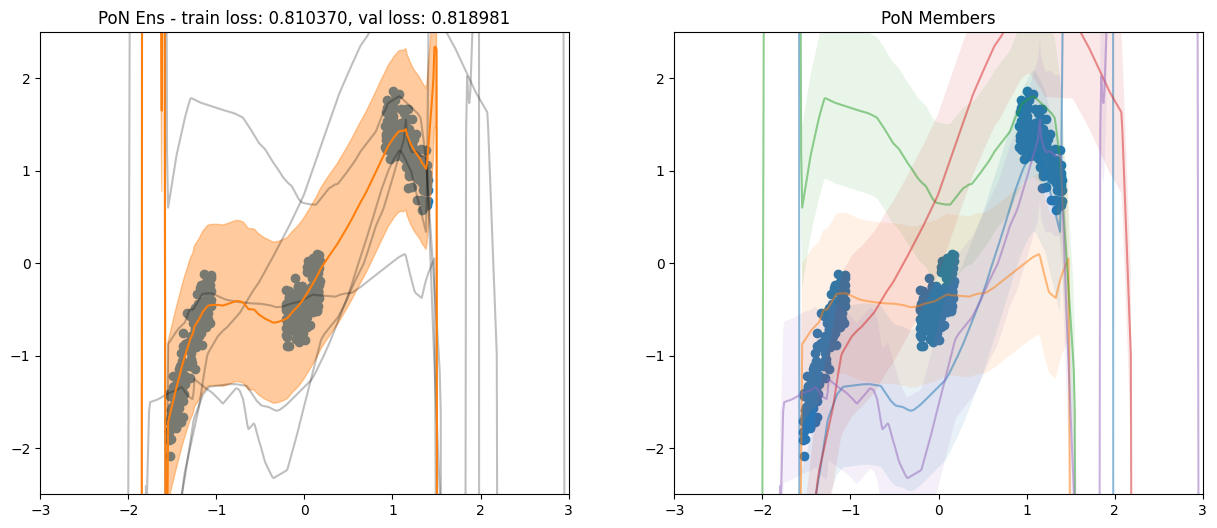

Best val_err
epoch: 171 - train loss: 0.80938, val loss: 0.81806, train err: 0.0416, val err: 0.0562, lr: 0.00010
Best val_err
epoch: 172 - train loss: 0.80839, val loss: 0.81716, train err: 0.0415, val err: 0.0561, lr: 0.00010
Best val_err
epoch: 173 - train loss: 0.80741, val loss: 0.81626, train err: 0.0413, val err: 0.0561, lr: 0.00010
Best val_err
epoch: 174 - train loss: 0.80642, val loss: 0.81537, train err: 0.0412, val err: 0.0561, lr: 0.00010
Best val_err
epoch: 175 - train loss: 0.80544, val loss: 0.81448, train err: 0.0411, val err: 0.0560, lr: 0.00010
Best val_err
epoch: 176 - train loss: 0.80446, val loss: 0.81359, train err: 0.0409, val err: 0.0560, lr: 0.00010
Best val_err
epoch: 177 - train loss: 0.80348, val loss: 0.81270, train err: 0.0408, val err: 0.0560, lr: 0.00010
Best val_err
epoch: 178 - train loss: 0.80251, val loss: 0.81177, train err: 0.0407, val err: 0.0559, lr: 0.00010
Best val_err
epoch: 179 - train loss: 0.80154, val loss: 0.81084, train err: 0.0406, val

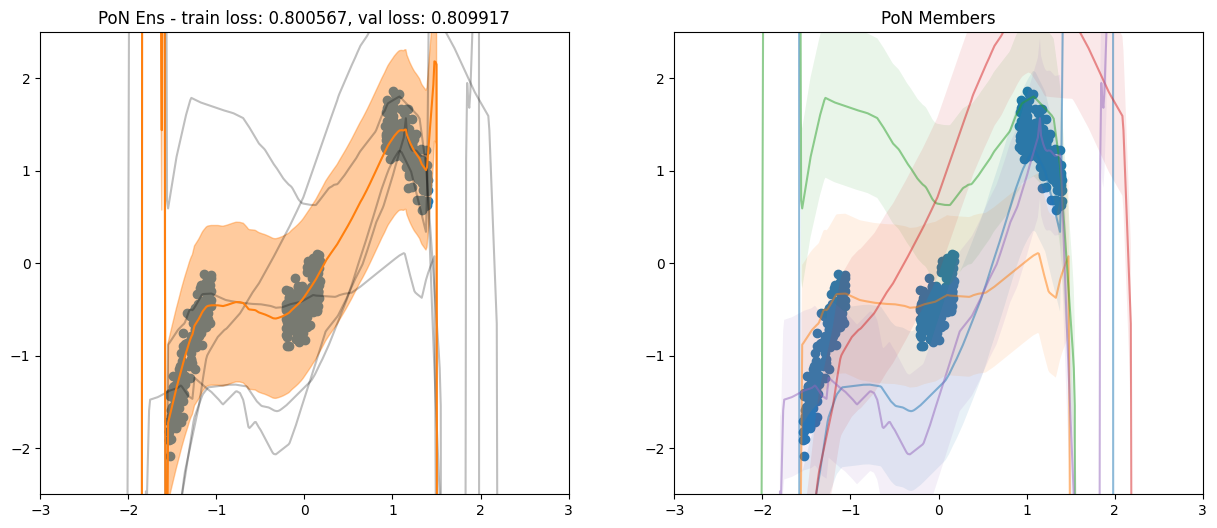

Best val_err
epoch: 181 - train loss: 0.79960, val loss: 0.80902, train err: 0.0403, val err: 0.0557, lr: 0.00010
Best val_err
epoch: 182 - train loss: 0.79863, val loss: 0.80813, train err: 0.0402, val err: 0.0557, lr: 0.00010
Best val_err
epoch: 183 - train loss: 0.79766, val loss: 0.80726, train err: 0.0401, val err: 0.0557, lr: 0.00010
epoch: 184 - train loss: 0.79670, val loss: 0.80638, train err: 0.0400, val err: 0.0557, lr: 0.00010
Best val_err
epoch: 185 - train loss: 0.79573, val loss: 0.80550, train err: 0.0399, val err: 0.0557, lr: 0.00010
Best val_err
epoch: 186 - train loss: 0.79477, val loss: 0.80462, train err: 0.0398, val err: 0.0557, lr: 0.00010
Best val_err
epoch: 187 - train loss: 0.79380, val loss: 0.80373, train err: 0.0397, val err: 0.0556, lr: 0.00010
Best val_err
epoch: 188 - train loss: 0.79284, val loss: 0.80284, train err: 0.0396, val err: 0.0556, lr: 0.00010
Best val_err
epoch: 189 - train loss: 0.79188, val loss: 0.80191, train err: 0.0395, val err: 0.0555,

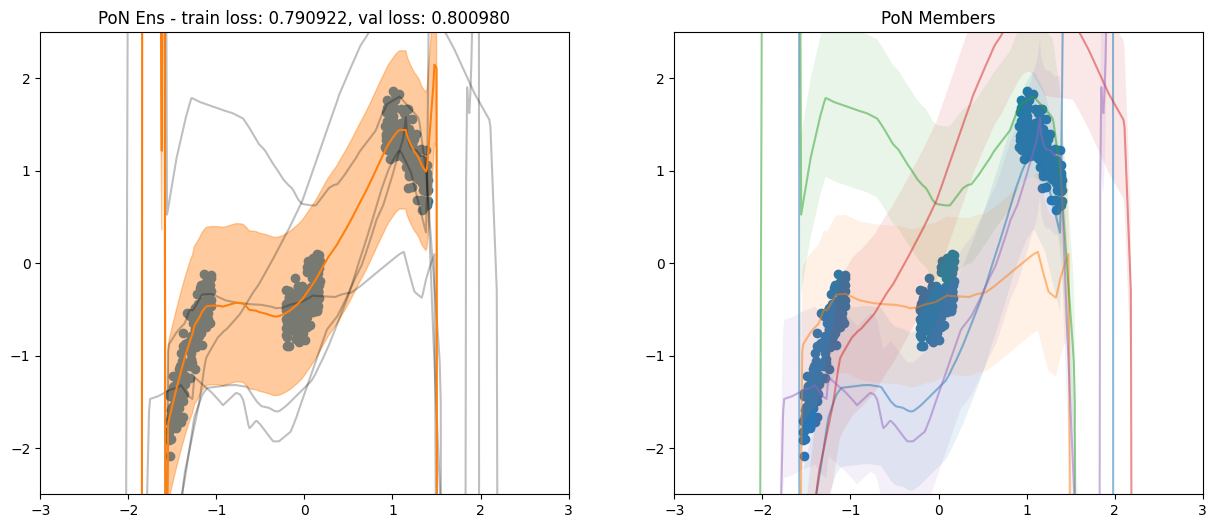

Best val_err
epoch: 191 - train loss: 0.78997, val loss: 0.80006, train err: 0.0393, val err: 0.0554, lr: 0.00010
Best val_err
epoch: 192 - train loss: 0.78901, val loss: 0.79914, train err: 0.0392, val err: 0.0553, lr: 0.00010
Best val_err
epoch: 193 - train loss: 0.78805, val loss: 0.79824, train err: 0.0392, val err: 0.0553, lr: 0.00010
Best val_err
epoch: 194 - train loss: 0.78710, val loss: 0.79734, train err: 0.0391, val err: 0.0553, lr: 0.00010
Best val_err
epoch: 195 - train loss: 0.78614, val loss: 0.79644, train err: 0.0390, val err: 0.0552, lr: 0.00010
Best val_err
epoch: 196 - train loss: 0.78519, val loss: 0.79555, train err: 0.0389, val err: 0.0552, lr: 0.00010
Best val_err
epoch: 197 - train loss: 0.78424, val loss: 0.79463, train err: 0.0388, val err: 0.0551, lr: 0.00010
Best val_err
epoch: 198 - train loss: 0.78328, val loss: 0.79371, train err: 0.0387, val err: 0.0551, lr: 0.00010
Best val_err
epoch: 199 - train loss: 0.78233, val loss: 0.79277, train err: 0.0386, val

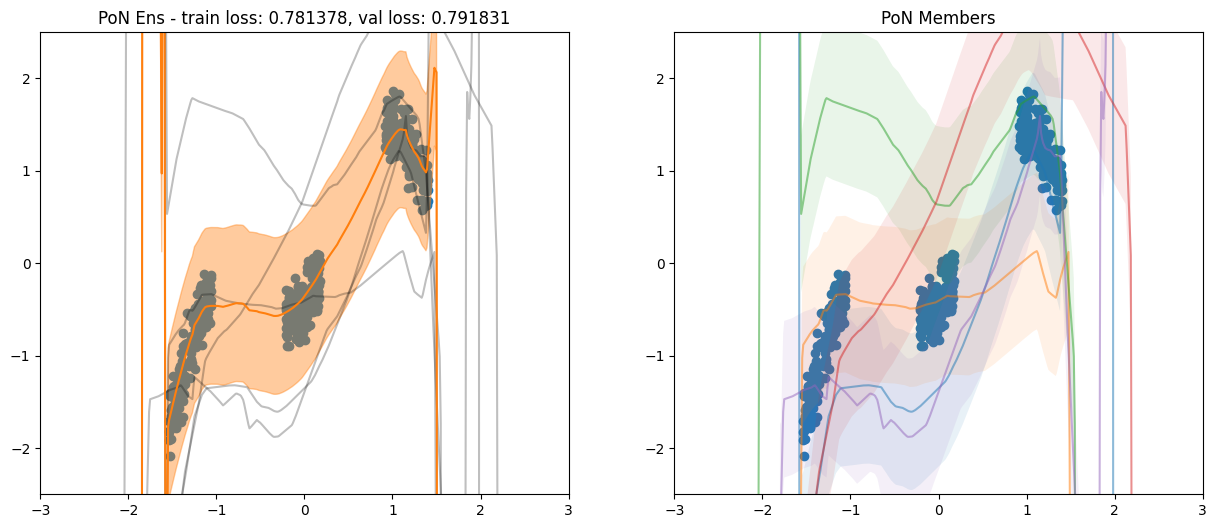

Best val_err
epoch: 201 - train loss: 0.78043, val loss: 0.79091, train err: 0.0385, val err: 0.0548, lr: 0.00010
Best val_err


In [11]:
config = get_pon_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_x = train_dataset[0][0]
init_y = train_dataset[0][1]


best_pon_states = []
for i in range(1):
    rng = random.PRNGKey(i)

    setup_rng, rng = random.split(rng)

    pon_model, state = setup_training(config, setup_rng, init_x, init_y)

    if PON_RETRAIN:  # RETRAIN
        state, best_state = train_loop(
            pon_model, state, config, rng, make_PoN_Ens_loss, make_PoN_Ens_loss, train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'offline',
                # 'notes': '',
            },
            plot_fn=make_PoN_Ens_plots,
        )

        best_pon_states.append(best_state)

        save_checkpoint(f'dynNN_results/pon_model_{i}_presentation', best_state, 1, overwrite=True)

In [11]:
# if PON_RETRAIN:  # RETRAIN
#     save_checkpoint('dynNN_results/pon_models', best_pon_states, 1, overwrite=True)

## Paper Plots

In [14]:
# # restored_pog_models = restore_checkpoint('dynNN_results/pog_models', 1)
# restored_pog_models = {f'{i}': restore_checkpoint(f'dynNN_results/pog_model_{i}', 1) for i in range(3)}
# restored_ens_models = restore_checkpoint('dynNN_results/ens_model_2', 1)
# # restored_ens_models = {f'{i}': restore_checkpoint(f'dynNN_results/ens_model_{i}', 1) for i in range(3)}
# restored_pon_models = restore_checkpoint('dynNN_results/pon_model_2', 1)
# # restored_pon_models = {f'{i}': restore_checkpoint(f'dynNN_results/pon_model_{i}', 1) for i in range(3)}


restored_pog_models = {"0": restore_checkpoint('dynNN_results/pog_model_0_presentation', 1)}
restored_ens_models = {"0": restore_checkpoint('dynNN_results/ens_model_0_presentation', 1)}
restored_pon_models = {"0": restore_checkpoint('dynNN_results/pon_model_0_presentation_reg_ens', 1)}
restored_pon_models_correct = {"0": restore_checkpoint('dynNN_results/pon_model_0_presentation', 1)}

In [15]:
text_width = 6.75133 # in  --> Confirmed with template explanation
line_width = 3.25063
dpi = 400

fs_m1 = 7  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=False)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [16]:
X_test, y_test = list(zip(*test_loader.dataset))

In [17]:
def uniform_entropy(loc, scale):
    upper = loc + scale
    lower = loc - scale
    # return jnp.log(upper - lower)
    uni = distrax.Uniform(lower, upper)
    return uni.entropy()

def uniform_nll(loc, scale, y):
    upper = loc + scale
    lower = loc - scale
    # return jnp.log(upper - lower)
    uni = distrax.Uniform(lower, upper)
    return -uni.log_prob(y)

In [18]:
def normal_entropy(loc, scale):
    norm = distrax.Normal(loc, scale)
    return norm.entropy()

def normal_nll(loc, scale, y):
    norm = distrax.Normal(loc, scale)
    return -norm.log_prob(y)

In [19]:
def mse(loc, y):
    return jnp.mean((loc - y)**2)

In [20]:
results_df = pd.DataFrame(columns=['model_name', 'n_members', 'random_seed', 'H', 'mse', 'nll'])
results_df

Empty DataFrame
Columns: [model_name, n_members, random_seed, H, mse, nll]
Index: []

In [21]:
s = set(range(5))
power_set = sum(map(lambda r: list(combinations(s, r)), range(1, len(s)+1)), [])

for (model, model_name) in [(pog_model, 'PoG'), (ens_model, 'Ens'), (pon_model, 'PoN'), (pon_model, 'PoN_correct')]:
    for i in range(1):
        if model_name == 'PoG':
            state = restored_pog_models[f'{i}']
        elif model_name == 'Ens':
            state = restored_ens_models[f'{i}']
        elif model_name == 'PoN':
            state = restored_pon_models[f'{i}']
        elif model_name == 'PoN_correct':
            state = restored_pon_models_correct[f'{i}']
        
        pred_fun = partial(
            model.apply,
            {"params": state['params'], **state['model_state']},
            train=False, return_ens_preds=True,
            method=model.pred
        )
        _, (locs, scales) = jax.vmap(
            pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
        )(jnp.array(X_test))

        for indices in power_set:
            n_members = len(indices)

            if model_name == 'PoG':
                loc, scale = calculate_pog_loc_scale(locs[indices, :, 0], scales[indices, :, 0])
                entropies = jax.vmap(uniform_entropy)(loc, scale)
                nlls_ = jax.vmap(uniform_nll)(loc, scale, jnp.array(y_test))
                infs = jnp.isinf(nlls_)
                print(f"dropping {infs.sum()} infs for prod of {n_members}")
                nlls = nlls_[~infs]
            elif model_name == 'Ens':
                loc, scale = calculate_ens_loc_scale(locs[indices, :, 0], scales[indices, :, 0], 1/n_members)
                entropies = jax.vmap(normal_entropy)(loc, scale)
                nlls = jax.vmap(normal_nll)(loc, scale, jnp.array(y_test))
            elif model_name == 'PoN' or model_name == 'PoN_correct':
                loc, scale = normal_prod(locs[indices, :, 0], scales[indices, :, 0], 1/n_members)
                entropies = jax.vmap(normal_entropy)(loc, scale)
                nlls = jax.vmap(normal_nll)(loc, scale, jnp.array(y_test))
            
            errors = jax.vmap(mse)(loc, jnp.array(y_test))

            results_df = pd.concat([
                results_df,
                pd.DataFrame({
                    'model_name': [model_name],
                    'n_members': [n_members],
                    'random_seed': [i],
                    'H': [entropies.mean()],
                    'nll': [nlls.mean()],
                    'mse': [errors.mean()],
                })],
                ignore_index=True
            )

PoG <class 'dict'>
dropping 4 infs for prod of 1
dropping 0 infs for prod of 1
dropping 2 infs for prod of 1
dropping 0 infs for prod of 1
dropping 1 infs for prod of 1
dropping 4 infs for prod of 2
dropping 6 infs for prod of 2
dropping 4 infs for prod of 2
dropping 5 infs for prod of 2
dropping 2 infs for prod of 2
dropping 0 infs for prod of 2
dropping 1 infs for prod of 2
dropping 2 infs for prod of 2
dropping 3 infs for prod of 2
dropping 1 infs for prod of 2
dropping 6 infs for prod of 3
dropping 4 infs for prod of 3
dropping 5 infs for prod of 3
dropping 6 infs for prod of 3
dropping 7 infs for prod of 3
dropping 5 infs for prod of 3
dropping 2 infs for prod of 3
dropping 3 infs for prod of 3
dropping 1 infs for prod of 3
dropping 3 infs for prod of 3
dropping 6 infs for prod of 4
dropping 7 infs for prod of 4
dropping 5 infs for prod of 4
dropping 7 infs for prod of 4
dropping 3 infs for prod of 4
dropping 7 infs for prod of 5
Ens <class 'dict'>
PoN <class 'dict'>
PoN_correct <

In [22]:
min_mse_df = results_df[results_df.n_members == 5][['model_name', 'random_seed', 'mse', 'nll']].rename(
    columns={'mse': 'final_mse', 'nll': 'final_nll'}
)
min_mse_df

model_name random_seed    final_mse    final_nll
30           PoG           0  0.031736363  -0.47447357
61           Ens           0  0.030034311   0.27382958
92           PoN           0  0.030034311   0.27233982
123  PoN_correct           0  0.031836227    0.7749002

In [23]:
tmp_df = results_df.merge(min_mse_df, on=['model_name', 'random_seed'], how='left')
tmp_df['mse_diff'] = tmp_df['mse'] - tmp_df['final_mse'] 
tmp_df['nll_diff'] = tmp_df['nll'] - tmp_df['final_nll'] 
tmp_df

model_name n_members random_seed           H          mse         nll  \
0            PoG         1           0  0.43111825    0.1895712  0.43111822   
1            PoG         1           0  0.43111825   0.09575166  0.43111825   
2            PoG         1           0  0.43111825   0.22272274  0.43111825   
3            PoG         1           0  0.43111825  0.042095102   0.4311183   
4            PoG         1           0   0.4311183  0.087536976  0.43111828   
..           ...       ...         ...         ...          ...         ...   
119  PoN_correct         4           0   1.2527039   0.14453168    0.853472   
120  PoN_correct         4           0   1.2527039   0.17287612   0.8732338   
121  PoN_correct         4           0   1.2527039   0.07203086  0.80292416   
122  PoN_correct         4           0   1.2527039  0.102600545  0.82423747   
123  PoN_correct         5           0   1.2527039  0.031836227   0.7749002   

       final_mse    final_nll     mse_diff     nll_diff  
0    0.031736363  -0.47447357   0.15783484    0.9055918  
1    0.031736363  -0.47447357    0.0640153   0.90559185  
2    0.031736363  -0.47447357   0.19098638   0.90559185  
3    0.031736363  -0.47447357   0.01035874   0.90559185  
4    0.031736363  -0.47447357  0.055800613   0.90559185  
..           ...          ...          ...          ...  
119  0.031836227    0.7749002  0.112695456    0.0785718  
120  0.031836227    0.7749002    0.1410399    0.0983336  
121  0.031836227    0.7749002   0.04019463  0.028023958  
122  0.031836227    0.7749002   0.07076432  0.049337268  
123  0.031836227    0.7749002          0.0          0.0  

[124 rows x 10 columns]

In [24]:
agg_df = tmp_df.groupby(by=['model_name', 'n_members']).agg({
    'H': ['mean', 'std', 'count'],
    'mse_diff': ['mean', 'std', 'count'],
    'mse': ['mean', 'std', 'count'],
    'nll_diff': ['mean', 'std', 'count'],
    'nll': ['mean', 'std', 'count'],
})
agg_df

H                      mse_diff                  \
                           mean           std count      mean       std count   
model_name  n_members                                                           
Ens         1          0.710392  0.000000e+00     5  0.000827  0.000708     5   
            2          0.711452  4.668710e-04    10  0.000310  0.000293    10   
            3          0.711807  4.054957e-04    10  0.000138  0.000186    10   
            4          0.711984  2.941170e-04     5  0.000052  0.000120     5   
            5          0.712091           NaN     1  0.000000       NaN     1   
PoG         1          0.431118  2.665601e-08     5  0.095799  0.075530     5   
            2          0.085209  1.891410e-01    10  0.036382  0.026010    10   
            3         -0.127303  1.979803e-01    10  0.022309  0.019126    10   
            4         -0.309148  1.752656e-01     5  0.010952  0.013593     5   
            5         -0.478102           NaN     1  0.000000       NaN     1   
PoN         1          0.710392  0.000000e+00     5  0.000827  0.000708     5   
            2          0.710392  0.000000e+00    10  0.000310  0.000293    10   
            3          0.710392  0.000000e+00    10  0.000138  0.000186    10   
            4          0.710392  0.000000e+00     5  0.000052  0.000120     5   
            5          0.710392           NaN     1  0.000000       NaN     1   
PoN_correct 1          1.252704  0.000000e+00     5  1.277654  0.917640     5   
            2          1.252704  0.000000e+00    10  0.479120  0.264111    10   
            3          1.252704  0.000000e+00    10  0.212942  0.110241    10   
            4          1.252704  0.000000e+00     5  0.079853  0.046174     5   
            5          1.252704           NaN     1  0.000000       NaN     1   

                            mse                  nll_diff                      \
                           mean       std count      mean           std count   
model_name  n_members                                                           
Ens         1          0.030861  0.000708     5  0.000215  1.459695e-03     5   
            2          0.030344  0.000293    10  0.000073  7.804625e-04    10   
            3          0.030172  0.000186    10  0.000032  5.104739e-04    10   
            4          0.030086  0.000120     5  0.000012  3.286855e-04     5   
            5          0.030034       NaN     1  0.000000           NaN     1   
PoG         1          0.127536  0.075530     5  0.905592  2.665601e-08     5   
            2          0.068119  0.026010    10  0.562609  1.873317e-01    10   
            3          0.054045  0.019126    10  0.350870  1.959247e-01    10   
            4          0.042689  0.013593     5  0.169282  1.734358e-01     5   
            5          0.031736       NaN     1  0.000000           NaN     1   
PoN         1          0.030861  0.000708     5  0.001705  1.459702e-03     5   
            2          0.030344  0.000293    10  0.000639  6.045929e-04    10   
            3          0.030172  0.000186    10  0.000284  3.833988e-04    10   
            4          0.030086  0.000120     5  0.000107  2.481376e-04     5   
            5          0.030034       NaN     1  0.000000           NaN     1   
PoN_correct 1          1.309491  0.917640     5  0.890785  6.397816e-01     5   
            2          0.510957  0.264111    10  0.334045  1.841389e-01    10   
            3          0.244779  0.110241    10  0.148464  7.686040e-02    10   
            4          0.111690  0.046174     5  0.055674  3.219268e-02     5   
            5          0.031836       NaN     1  0.000000           NaN     1   

                            nll                      
                           mean           std count  
model_name  n_members                                
Ens         1          0.274045  1.459695e-03     5  
            2          0.273902  7.804625e-04    10  
            3          0.273861 

In [25]:
agg_df[('H', 'std_err')] = agg_df[('H', 'std')] / agg_df[('H', 'count')]
agg_df[('mse_diff', 'std_err')] = agg_df[('mse_diff', 'std')] / agg_df[('mse_diff', 'count')]
agg_df[('mse', 'std_err')] = agg_df[('mse', 'std')] / agg_df[('mse', 'count')]
agg_df[('nll_diff', 'std_err')] = agg_df[('nll_diff', 'std')] / agg_df[('nll_diff', 'count')]
agg_df[('nll', 'std_err')] = agg_df[('nll', 'std')] / agg_df[('nll', 'count')]
agg_df

H                      mse_diff                  \
                           mean           std count      mean       std count   
model_name  n_members                                                           
Ens         1          0.710392  0.000000e+00     5  0.000827  0.000708     5   
            2          0.711452  4.668710e-04    10  0.000310  0.000293    10   
            3          0.711807  4.054957e-04    10  0.000138  0.000186    10   
            4          0.711984  2.941170e-04     5  0.000052  0.000120     5   
            5          0.712091           NaN     1  0.000000       NaN     1   
PoG         1          0.431118  2.665601e-08     5  0.095799  0.075530     5   
            2          0.085209  1.891410e-01    10  0.036382  0.026010    10   
            3         -0.127303  1.979803e-01    10  0.022309  0.019126    10   
            4         -0.309148  1.752656e-01     5  0.010952  0.013593     5   
            5         -0.478102           NaN     1  0.000000       NaN     1   
PoN         1          0.710392  0.000000e+00     5  0.000827  0.000708     5   
            2          0.710392  0.000000e+00    10  0.000310  0.000293    10   
            3          0.710392  0.000000e+00    10  0.000138  0.000186    10   
            4          0.710392  0.000000e+00     5  0.000052  0.000120     5   
            5          0.710392           NaN     1  0.000000       NaN     1   
PoN_correct 1          1.252704  0.000000e+00     5  1.277654  0.917640     5   
            2          1.252704  0.000000e+00    10  0.479120  0.264111    10   
            3          1.252704  0.000000e+00    10  0.212942  0.110241    10   
            4          1.252704  0.000000e+00     5  0.079853  0.046174     5   
            5          1.252704           NaN     1  0.000000       NaN     1   

                            mse                  nll_diff                      \
                           mean       std count      mean           std count   
model_name  n_members                                                           
Ens         1          0.030861  0.000708     5  0.000215  1.459695e-03     5   
            2          0.030344  0.000293    10  0.000073  7.804625e-04    10   
            3          0.030172  0.000186    10  0.000032  5.104739e-04    10   
            4          0.030086  0.000120     5  0.000012  3.286855e-04     5   
            5          0.030034       NaN     1  0.000000           NaN     1   
PoG         1          0.127536  0.075530     5  0.905592  2.665601e-08     5   
            2          0.068119  0.026010    10  0.562609  1.873317e-01    10   
            3          0.054045  0.019126    10  0.350870  1.959247e-01    10   
            4          0.042689  0.013593     5  0.169282  1.734358e-01     5   
            5          0.031736       NaN     1  0.000000           NaN     1   
PoN         1          0.030861  0.000708     5  0.001705  1.459702e-03     5   
            2          0.030344  0.000293    10  0.000639  6.045929e-04    10   
            3          0.030172  0.000186    10  0.000284  3.833988e-04    10   
            4          0.030086  0.000120     5  0.000107  2.481376e-04     5   
            5          0.030034       NaN     1  0.000000           NaN     1   
PoN_correct 1          1.309491  0.917640     5  0.890785  6.397816e-01     5   
            2          0.510957  0.264111    10  0.334045  1.841389e-01    10   
            3          0.244779  0.110241    10  0.148464  7.686040e-02    10   
            4          0.111690  0.046174     5  0.055674  3.219268e-02     5   
            5          0.031836       NaN     1  0.000000           NaN     1   

                            nll                                 H  mse_diff  \
                           mean           std count       std_err   std_err   
model_name  n_members                                                         
Ens         1          0.274045  1.459695e-03     5  0.000000e+00

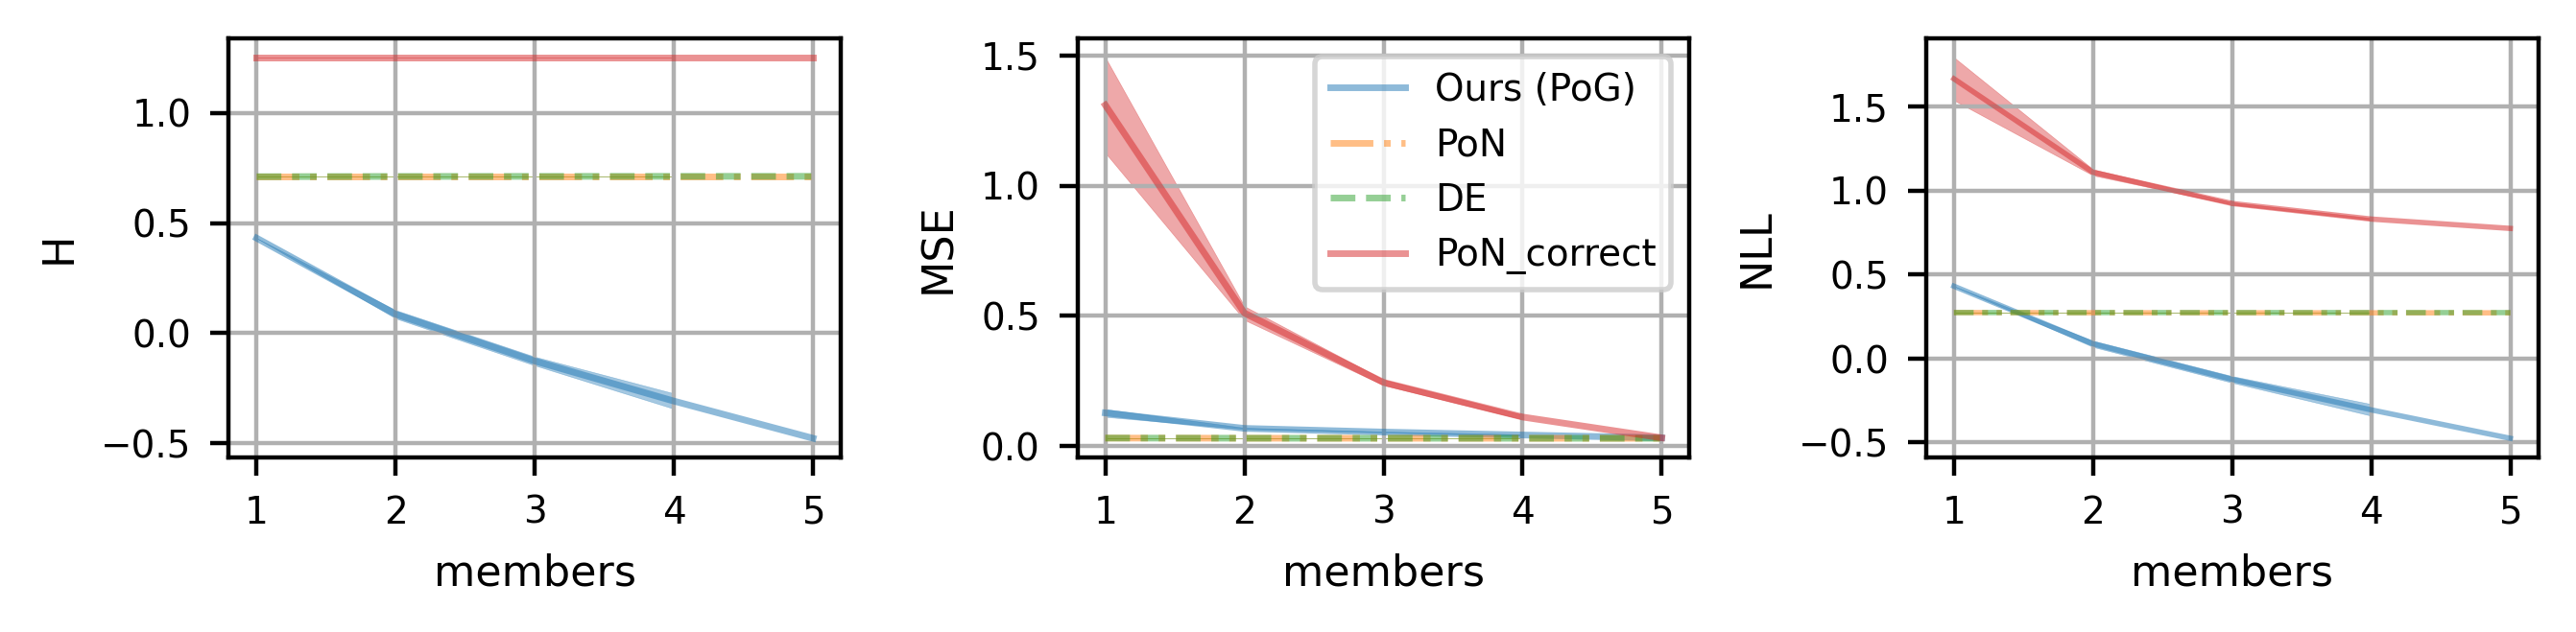

In [26]:
# matplotlib.style.use('default')
fig, axs = plt.subplots(1, 3, figsize=(text_width, text_width/4.), dpi=dpi, sharey=False, sharex=True, layout='tight')

names = {
    'PoG': 'Ours (PoG)',
    'Ens': 'DE',
    'PoN': 'PoN',
    'PoN_correct': 'PoN_correct',
}

linestyles = {
    'PoG': '-',
    'Ens': '--',
    'PoN': '-.',
    'PoN_correct': '-',
}

H_df = agg_df['H'].reset_index()
for i, model_name in enumerate(['PoG', 'PoN', 'Ens', 'PoN_correct']):
    x = H_df[H_df.model_name == model_name]['n_members']
    y = H_df[H_df.model_name == model_name]['mean']
    y_err = H_df[H_df.model_name == model_name]['std_err']

    axs[0].plot(x, y, linestyles[model_name], c=f'C{i}', lw=1.25, alpha=0.5)
    axs[0].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[0].grid(0.3)
axs[0].set_ylabel('H')
axs[0].set_xlabel('members')
axs[0].set_xticks([1, 2, 3, 4, 5])

err_df = agg_df['mse'].reset_index()
for i, model_name in enumerate(['PoG', 'PoN', 'Ens', 'PoN_correct']):
    x = err_df[err_df.model_name == model_name]['n_members']
    y = err_df[err_df.model_name == model_name]['mean']
    y_err = err_df[err_df.model_name == model_name]['std_err']

    axs[1].plot(x, y, linestyles[model_name], c=f'C{i}', lw=1.25, alpha=0.5, label=names[model_name])
    axs[1].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[1].grid(0.3)
axs[1].set_ylabel('MSE')
axs[1].set_xlabel('members')
axs[1].set_xticks([1, 2, 3, 4, 5])

nll_df = agg_df['nll'].reset_index()
for i, model_name in enumerate(['PoG', 'PoN', 'Ens', 'PoN_correct']):
    x = nll_df[nll_df.model_name == model_name]['n_members']
    y = nll_df[nll_df.model_name == model_name]['mean']
    y_err = nll_df[nll_df.model_name == model_name]['std_err']

    axs[2].plot(x, y, linestyles[model_name], c=f'C{i}', lw=1., alpha=0.5, label=names[model_name])
    axs[2].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[2].grid(0.2)
axs[2].set_ylabel('NLL')
axs[2].set_xlabel('members')
axs[2].set_xticks([1, 2, 3, 4, 5])
axs[1].legend()

plt.show()

# plt.savefig(f'toy_entropy_err_nll_evolution.pdf', dpi=dpi, bbox_inches='tight')